<h1 align='center'> Impact of HbA1c Measurement on Hospital Readmission Rates </h1>
<h4 align='center'> Analysis of 70,000 Clinical Database Patient Records </h4> 

## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Objective

In this Jupyter Notepad, we will using the 130-US hospitals Dataset to predict whether an individual will be readmitted based on the diabetes data.

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

## 2. Loading the required Data

> I have kept my data in a folder called "Diabetes" which is then again kept in a folder called "ML DATA"

In [2]:
# Import the required data.
df = pd.read_csv('ML DATA/Diabetes/diabetics_data.csv')

In [3]:
# Viewing the train dataset
pd.set_option('display.max_columns', None)
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1          None   
1                 0     276  250.01    255                 9          None   
2                 1     648     250    V27                 6          None   
3                 0       8  250.43    403                 7          None   
4                 0     197     157    250                 5          None   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      None        No          No          No             No          No   
1      None        No          No          No             No          No   
2      None        No          No          No             No          No   
3      None        No          No          No             No          No   
4      None        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

> Here we can see that there are many '?' symbols for the missing data. We shall replace this by Null values. This will make it easier for us to manipulate on the future.

In [4]:
# Replacing all '?' with Null values.
df.replace('?',np.nan, inplace= True)

In [5]:
print("Dimensionality of the dataset: ", df.shape)

Dimensionality of the dataset:  (101766, 50)


### Data Dictionary

- **Patient number (Numeric Unique identifier of a patient) ** 

- **Race : ** Caucasian, Asian, African American, Hispanic, and other 

- **Gender: ** male, female, and unknown/invalid

- **Age **  

- **Admission type ** 

- **Discharge disposition ** 

- **Admission source ** 

- **Time in hospital **  

- **Medical specialty ** 

- **Number of lab procedures ** 

- **Number of procedures ** 

- **Number of medications **   

- **Diagnosis 1 ** 

- **Diagnosis 2 ** 

- **Diagnosis 3 ** 

- **Glucose serum test result: ** ">200", ">300", "normal", "none" = measured

- **A1c test result: **  ">8" = result was greater than 8%.  ">7" = result was greater than 7% but less than 8%.  "normal" = result                             was less than 7%. "none" = not measured.

- **Change of medications: ** "change", "no change" 

- **Diabetes medications: **  "yes", "no" 

- **24 features for medications: ** 
> metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone.


- **Readmitted: **  "<30" = if the patient was readmitted in less than 30 days.
                    ">30" if the patient was readmitted in more than 30 days.
                    "No" for no record of readmission.

## 3. Exploratory Data Analysis

**PROBLEM: ** To predict whether if a particular person was readmitted based on the information provided in the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
# Describing all the Numerical Features
df.describe()

encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.000000          4.000000   
75%                    4.000000             7.000000          6.000000   
max                   28.000000            25.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count       101766.000000   101766.000000    101766.000000      101766.000000   
mean            43.095641        1.339730        16.021844           0.369357   
std             19.674362        1.705807         8.127566           1.267265   
min              1.000000        0.000000         1.000000           0.000000   
25%             31.000000        0.000000        10.000000           0.000000   
50%             44.000000        1.000000        15.000000           0.000000   
75%             57.000000        2.000000        20.000000           0.000000   
max            132.000000        6.000000        81.000000          42.000000   

       number_emergency  number_inpatient  number_diagnoses  
count     101766.000000     101766.000000     101766.000000  
mean           0.197836          0.635566          7.422607  
std            0.930472          1.262863          1.933600  
min            0.000000          0.000000          1.000000  
25%            0.000000          0.000000          6.000000  
50%            0.000000          0.000000          8.000000  
75%            0.000000          1.000000          9.000000  
max           76.000000         21.000000         16.000000

In [8]:
# Describing all the Categorical Features
df.describe(include=['O'])

race  gender      age    weight payer_code medical_specialty  \
count       99493  101766   101766      3197      61510             51817   
unique          5       3       10         9         17                72   
top     Caucasian  Female  [70-80)  [75-100)         MC  InternalMedicine   
freq        76099   54708    26068      1336      32439             14635   

        diag_1  diag_2  diag_3 max_glu_serum A1Cresult metformin repaglinide  \
count   101745  101408  100343        101766    101766    101766      101766   
unique     716     748     789             4         4         4           4   
top        428     276     250          None      None        No          No   
freq      6862    6752   11555         96420     84748     81778      100227   

       nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
count       101766         101766      101766        101766    101766   
unique           4              4           4             2         4   
top             No             No          No            No        No   
freq        101063         101680       96575        101765     89080   

       glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
count     101766      101766       101766        101766   101766   101766   
unique         4           2            4             4        4        4   
top           No          No           No            No       No       No   
freq       91116      101743        94438         95401   101458   101728   

       troglitazone tolazamide examide citoglipton insulin  \
count        101766     101766  101766      101766  101766   
unique            2          3       1           1       4   
top              No         No      No          No      No   
freq         101763     101727  101766      101766   47383   

       glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
count               101766              101766                   101766   
unique                   4                   2                        2   
top                     No                  No                       No   
freq                101060              101753                   101765   

       metformin-rosiglitazone metformin-pioglitazone  change diabetesMed  \
count                   101766                 101766  101766      101766   
unique                       2                      2       2           2   
top                         No                     No      No         Yes   
freq                    101764                 101765   54755       78363   

       readmitted  
count      101766  
unique          3  
top            NO  
freq        54864

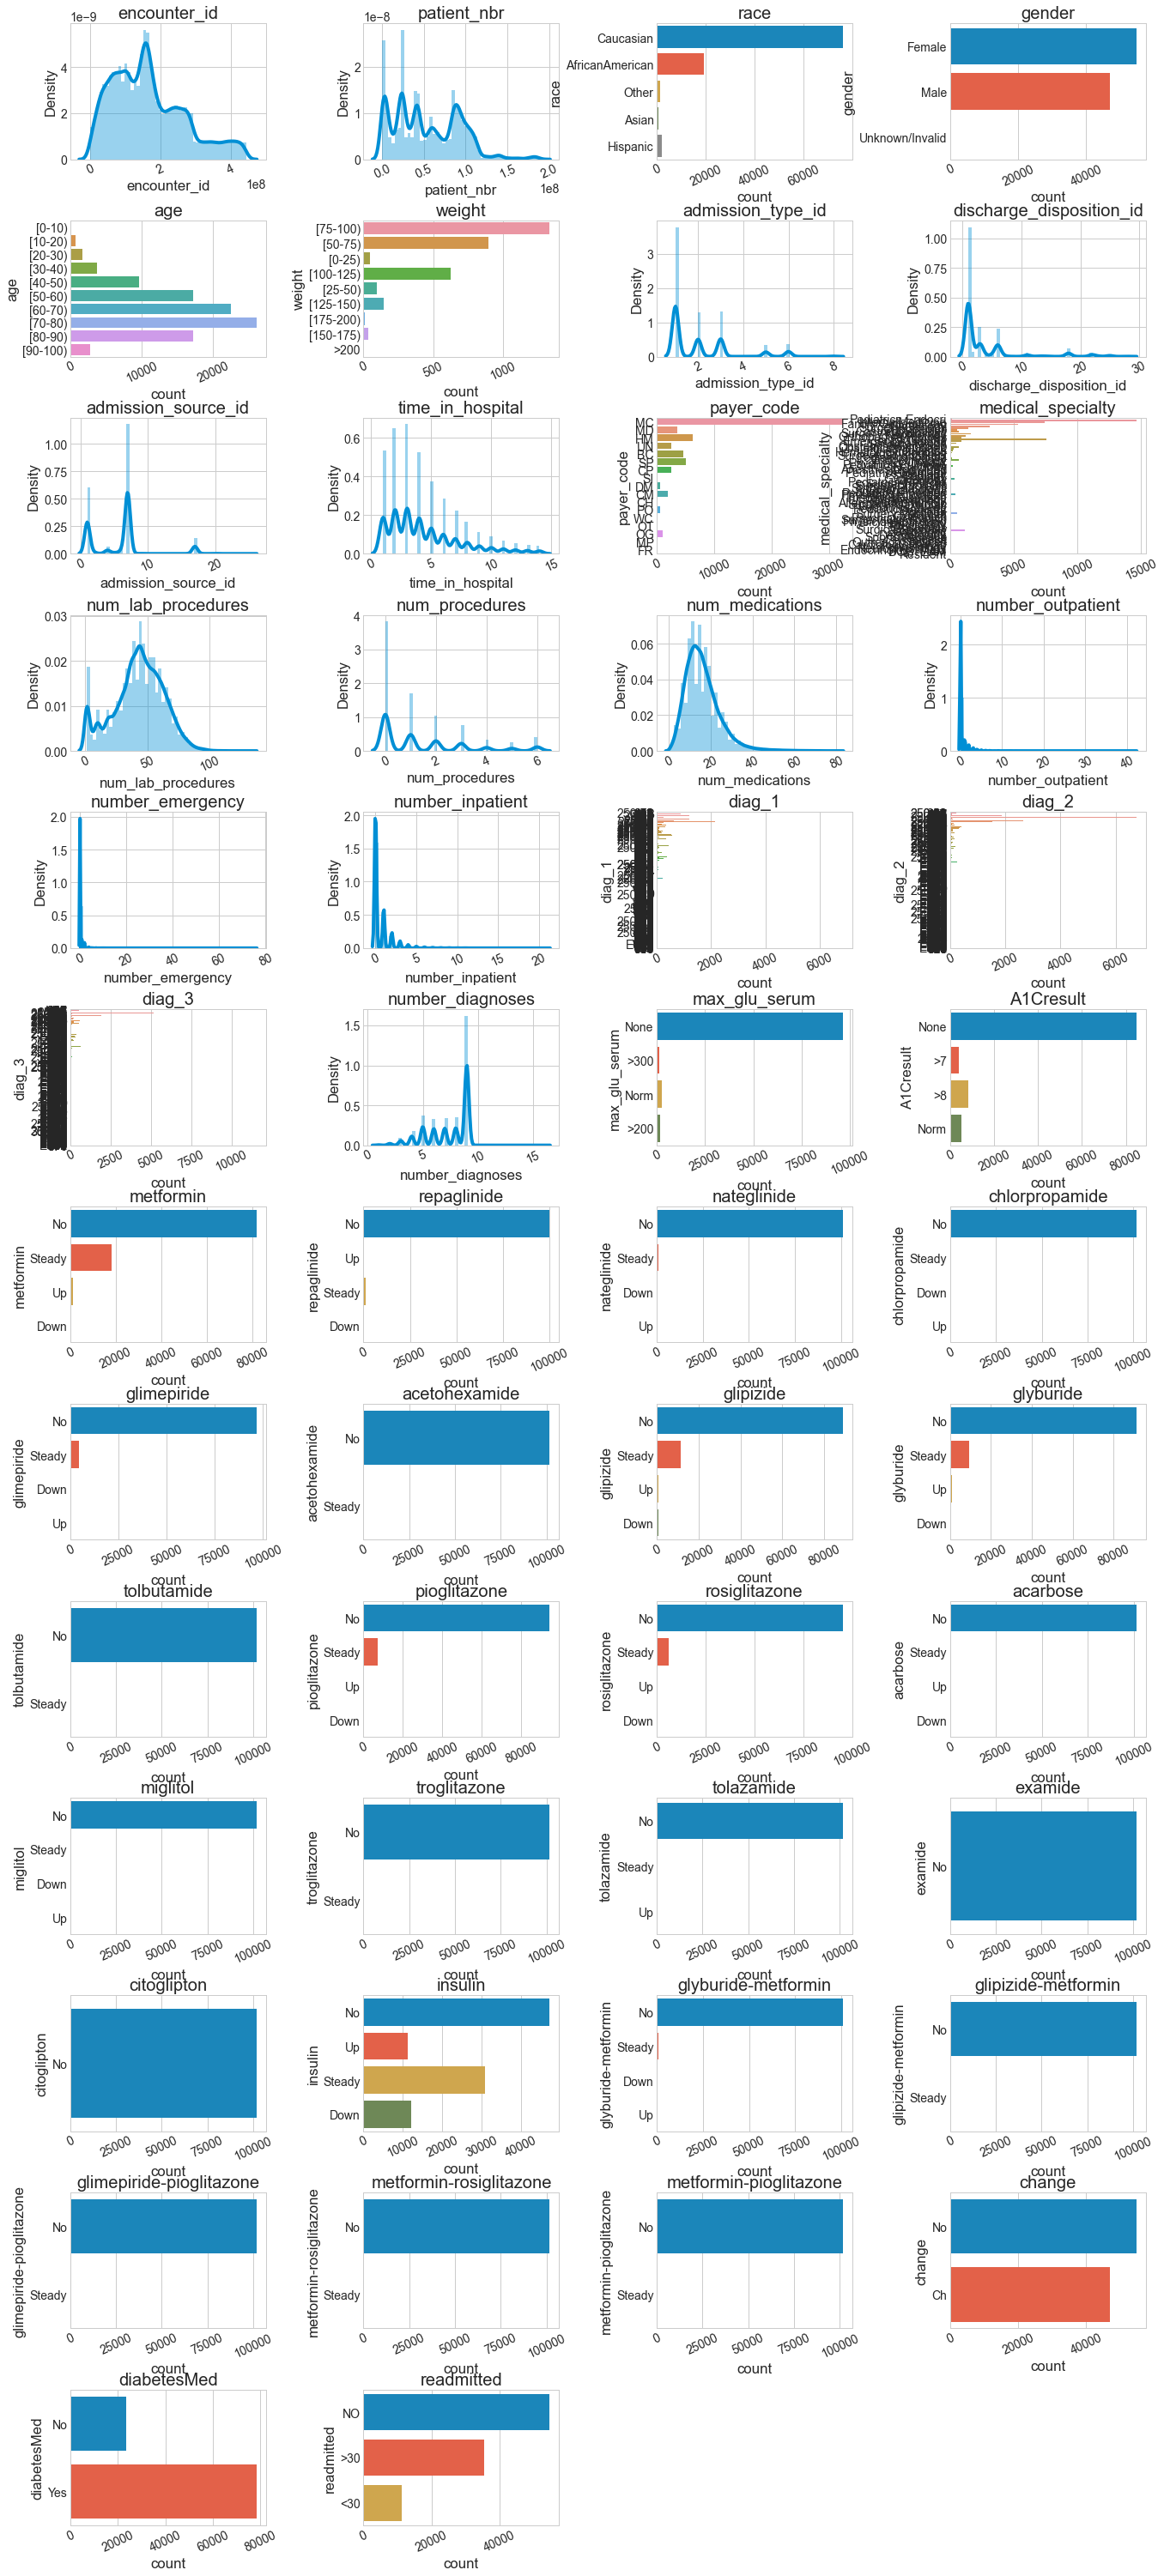

In [9]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):    # Gives us 2 loop variables
                                                    # i --> The count of the current iteration.
                                                    # column --> The value of the item at the current iteration.
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df, cols= 4, width=20, height=50, hspace=0.45, wspace=0.5)

### wspace = The width of the padding between subplots.
### hspace = The height of the padding between subplots.

- With ***enumerate()***, you don’t need to remember to access the item from the iterable, and you don’t need to remember to advance the index at the end of the loop.

This was taken from : https://realpython.com/python-enumerate/

### Missing Values

- In any dataset we will initially try to find out where the missing data are. 

<AxesSubplot:>

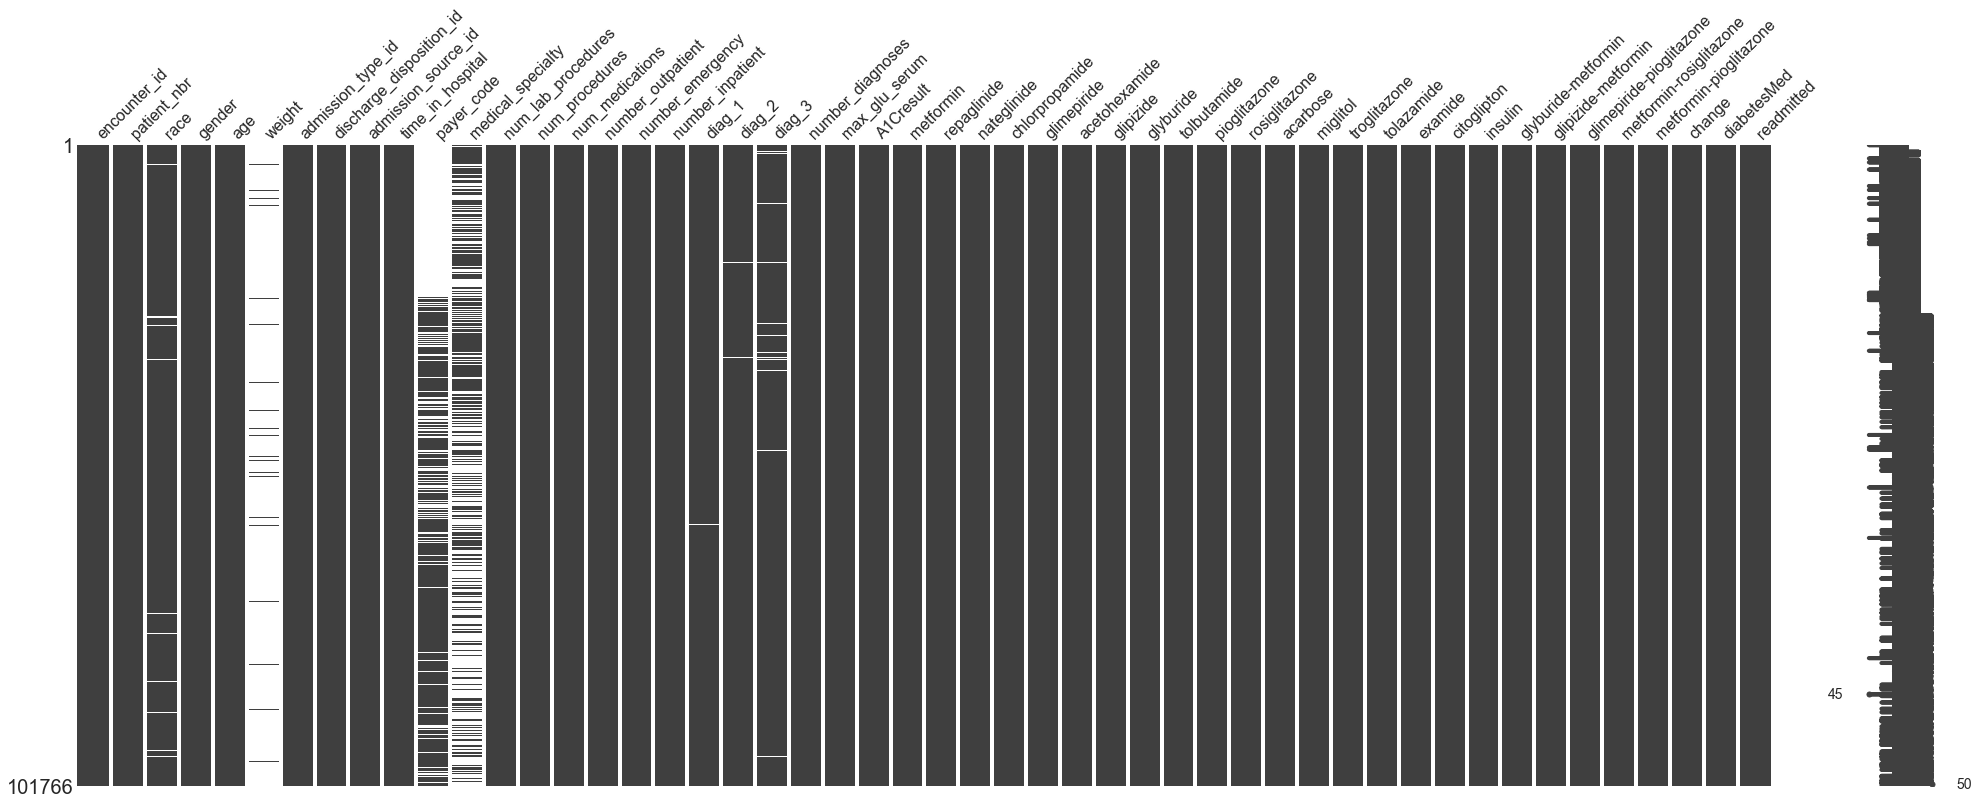

In [10]:
# To plot a graphic of missing values
missingno.matrix(df,figsize=(30,11))

- It is important to visualise missing values, because then you will know what are the major NaN values in your dataset.
- Here we can see that the 'weight', 'payer_code','medical_specialty' columns has quite a few missing values.

In [11]:
# To get the Percentage of missing values.
col = ['race', 'gender', 'age', 'weight','admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

def missing_percentage(df,columns):
    for i in columns:
        per = np.round(((df.isnull().sum())/len(df))*100,2)
    return per

missing_percentage(df= df,columns= col)

## np.round(((df.isnull().sum())/len(df))*100,2)        --> If this is given directly also it yields the same result.

encounter_id                 0.00
patient_nbr                  0.00
race                         2.23
gender                       0.00
age                          0.00
weight                      96.86
admission_type_id            0.00
discharge_disposition_id     0.00
admission_source_id          0.00
time_in_hospital             0.00
payer_code                  39.56
medical_specialty           49.08
num_lab_procedures           0.00
num_procedures               0.00
num_medications              0.00
number_outpatient            0.00
number_emergency             0.00
number_inpatient             0.00
diag_1                       0.02
diag_2                       0.35
diag_3                       1.40
number_diagnoses             0.00
max_glu_serum                0.00
A1Cresult                    0.00
metformin                    0.00
repaglinide                  0.00
nateglinide                  0.00
chlorpropamide               0.00
glimepiride                  0.00
acetohexamide 

> - Weight attribute is considered to be too sparse and it will not included in further analysis. 
- Payer code is removed since it had a high percentage of missing values and it thus not considered relevant to the outcome.
- Medical specialty attribute is maintained, adding the value “missing” in order to account for missing values. 

***Large percentage of missing values of the weight attribute can be explained by the fact that prior to the HITECH legislation of the American Reinvestment and Recovery Act in 2009 hospitals and clinics were not required to capture it in a structured format.***

In [12]:
# Removing and manipulating the columns.
df.drop(columns= ['weight', 'payer_code'],axis=1, inplace= True)
df['medical_specialty'].fillna('missing',inplace= True)

### What Datatypes are there in the dataframe?

We usually consider features with a datatype of object as categorical features. And those with float or int could be numerical features.

However, sometimes the features that we consider as numerical might actually turn out to be categorical.

The next few steps will help us figure out how to process our data so our machine learning model can learn from it.
Ideally all the features will be encoded into a numerical value of some kind (maybe 0 or 1 / something else).

In [13]:
# Datatypes in the dataset
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide           

### Exploring each of these features 
We will go through each of the columns and see which all we can use in our first models. Some of them needs more preprocessing than the others to get ready.

When exploring our dataset and its features, we have many options available to us. We can explore each feature individually, or compare pairs of features, finding the correlation between. Let's start with some simple Univariate (one feature) analysis.

**Features can be of multiple types: **

- **Nominal: ** is for mutual exclusive, but not ordered, categories.
- **Ordinal: ** is one where the order matters but not the difference between values.
- **Interval: ** is a measurement where the difference between two values is meaningful.
- **Ratio: ** has all the properties of an interval variable, and also has a clear definition of 0.0.

**Cleaning: ** To clean our data, we'll need to work with:

- **Missing values:- ** Either omit elements from a dataset that contain missing values or impute them (fill them in).
- **Special values:- ** Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
- **Outliers:- ** They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
- **Obvious inconsistencies:- ** A person's age cannot be negative. Find the inconsistencies and plan for them.

### UNIVARIATE ANALYSIS

In [14]:
df.head()

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital         medical_specialty  num_lab_procedures  \
0                 1  Pediatrics-Endocrinology                  41   
1                 3                   missing                  59   
2                 2                   missing                  11   
3                 2                   missing                  44   
4                 1                   missing                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     NaN    NaN                 1          None   
1                 0     276  250.01    255                 9          None   
2                 1     648     250    V27                 6          None   
3                 0       8  250.43    403                 7          None   
4                 0     197     157    250                 5          None   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      None        No          No          No             No          No   
1      None        No          No          No             No          No   
2      None        No          No          No             No          No   
3      None        No          No          No             No          No   
4      None        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4                  No                  No                       No   

  metformin-rosiglitazone metformin-pioglitazo

FEATURE 1: Readmitted

Description: Whether the Patient was readmitted or not.

Key: "<30" = the patient was readmitted in less than 30 days. ">30" = the patient was readmitted in more than 30 days. "No" = no record of readmission.

***This is the variable we want our ML model to predict based off the others***

In [15]:
# To see the unique values in this column.
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [16]:
# How many missing values are there in readmitted
df['readmitted'].isnull().sum()

0

In [17]:
# Replacing the No's with 'N' and "<30",">30" with 'Y'
df['readmitted'] = df['readmitted'].replace('<30','Y')
df['readmitted'] = df['readmitted'].replace('>30','Y')
df['readmitted'] = df['readmitted'].replace('NO','N')

N    54864
Y    46902
Name: readmitted, dtype: int64


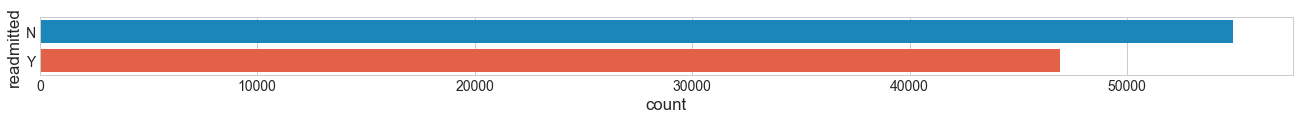

In [18]:
# How many patients were readmitted?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='readmitted',data= df)
#sns.countplot(x='readmitted',data= df)             --> You can use this to get a vertical graph.
 
print(df['readmitted'].value_counts())             ##This will help us see the exact number along with the graph.

- So here we can see that the people who were readmitted (46902) are far less than the ones who were'nt (54864). Thus, in the future when we run our model and we get that the number of people who were readmitted to be more then that means that there something wrong.

#### FEATURE 2: Patient Number
Description: Unique ID of a patient.

In [19]:
# To check if the patients unique number was duplicated.
df['patient_nbr'].duplicated().any()

True

> The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered as statistically independent (An assumption of the Logistic Regression Model). We will use only one encounter / patient, in particular,we considered only the first encounter for each patient as the primary admission and determine whether or not they were readmitted.

In [20]:
# To get the number of duplicated patient numbers.
df['patient_nbr'].duplicated().value_counts()

False    71518
True     30248
Name: patient_nbr, dtype: int64

In [21]:
# To see the rows which are duplicated.
df[df['patient_nbr'].duplicated() == True].head()

encounter_id  patient_nbr             race  gender      age  \
79        1070256     23043240        Caucasian  Female  [50-60)   
81        1077924     21820806  AfricanAmerican    Male  [50-60)   
143       2309376     41606064        Caucasian    Male  [20-30)   
175       2552952     86240259        Caucasian  Female  [70-80)   
307       3174918      5332491            Other  Female  [60-70)   

     admission_type_id  discharge_disposition_id  admission_source_id  \
79                   2                         1                    4   
81                   1                         6                    7   
143                  2                         1                    2   
175                  1                         3                    7   
307                  6                        25                    7   

     time_in_hospital medical_specialty  num_lab_procedures  num_procedures  \
79                  3           missing                  41               4   
81                  3           missing                  52               0   
143                 2           missing                  35               0   
175                11  InternalMedicine                  44               0   
307                 5  InternalMedicine                  58               1   

     num_medications  number_outpatient  number_emergency  number_inpatient  \
79                20                  0                 0                 1   
81                13                  0                 0                 2   
143               12                  0                 0                 1   
175               19                  0                 1                 6   
307               11                  0                 0                 1   

    diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
79     414     411    250                 7          None      None        No   
81     198     197    197                 9          None      None        No   
143    277  250.02    753                 3          None      None        No   
175    276       8    496                 8          None      None        No   
307    428     511    584                 7          None      None        No   

    repaglinide nateglinide chlorpropamide glimepiride acetohexamide  \
79           No          No             No          No            No   
81           No          No             No          No            No   
143          No          No             No          No            No   
175          No          No             No          No            No   
307          No          No             No          No            No   

    glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose  \
79         No        No          No           No            No       No   
81         No        No          No           No            No       No   
143        No        No          No           No            No       No   
175        No    Steady          No           No            No       No   
307        No        No          No           No            No       No   

    miglitol troglitazone tolazamide examide citoglipton insulin  \
79        No           No         No      No          No  Steady   
81        No           No         No      No          No      No   
143       No           No         No      No          No  Steady   
175       No           No         No      No          No      Up   
307       No           No         No      No          No  Steady   

    glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
79                   No                  No                       No   
81                   No                  No                       No   
143                  No                  No                       No   
175                  No                  No                       No   
307                  No                  No                       N

In [22]:
# Removing all the duplicated values except the first one.
df['patient_nbr'] = df['patient_nbr'].drop_duplicates(keep='first')

df.dropna(how= 'any', inplace= True)      # This is so that we remove all the Null values.

In [23]:
print("Dimensionality of the dataset: ", df.shape)

Dimensionality of the dataset:  (68358, 48)


FEATURE 3: Race

Description: A category of humankind that shares certain distinctive physical traits.

Key: Caucasian, Asian, African American, Hispanic, other

In [24]:
# Are there any missing values?
df['race'].isnull().sum()
#df['race'].isnull().any()            --> This will give a boolean answer.

0

<AxesSubplot:xlabel='count', ylabel='race'>

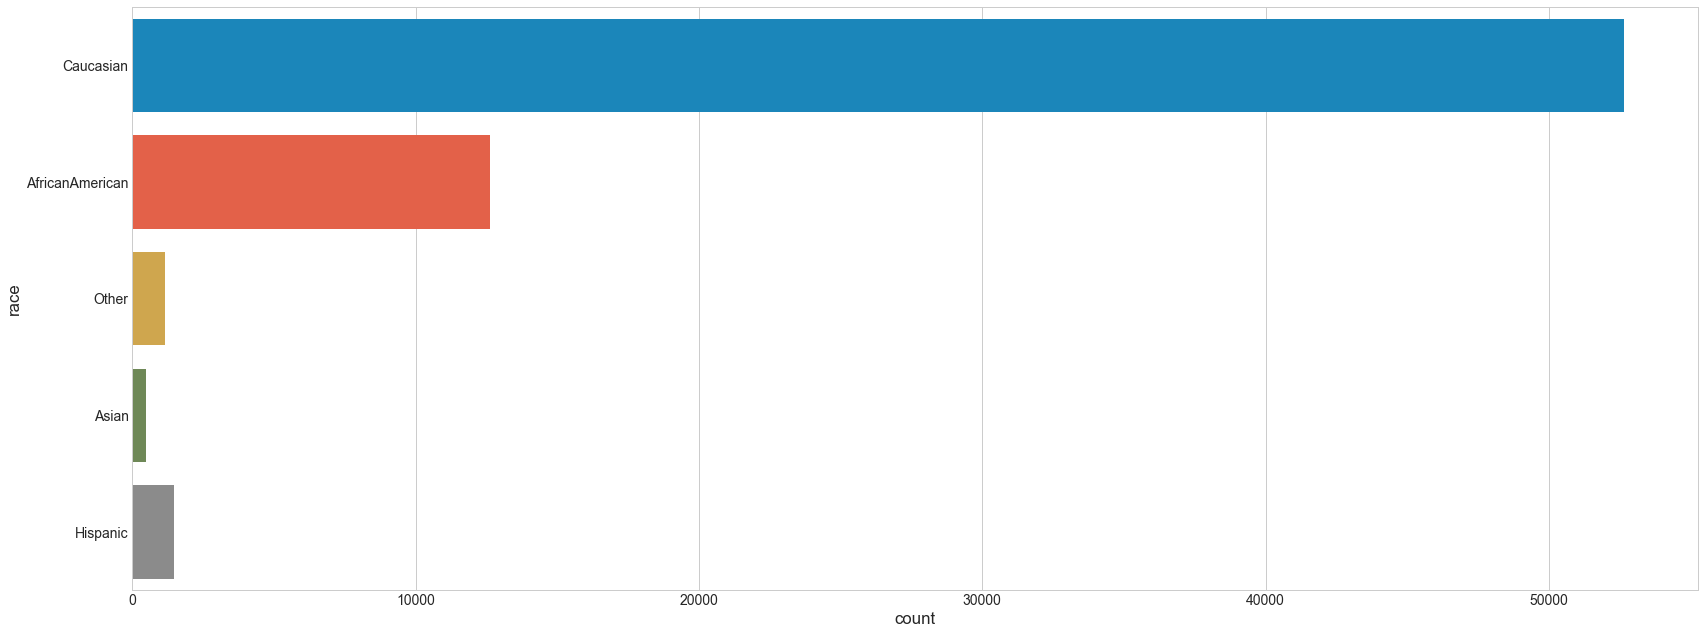

In [25]:
# Plot to see the different race in the data. 
fig = plt.figure(figsize= (25,10))
sns.countplot(y= 'race', data= df)

- So here we can see that most of the patients were from the Caucasian race (52638), then comes the African Americans (12611) are far more than Asians (483).

FEATURE 4: Gender

Description: The gender of the patient (male or female).

Key: Male, Female, unknown/invalid

In [26]:
# Are there any missing values?
df['gender'].isnull().sum()
#df['gender'.isnull().any()            --> This will give a boolean answer.

0

Female             36440
Male               31917
Unknown/Invalid        1
Name: gender, dtype: int64


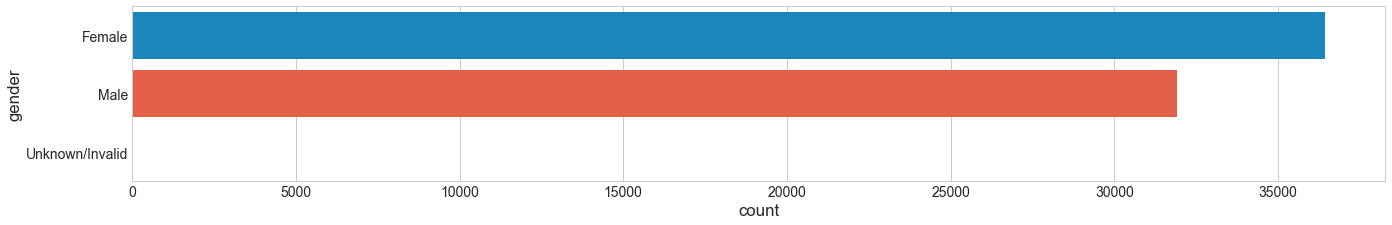

In [27]:
plt.figure(figsize=(20,3))
sns.countplot(y='gender',data= df)
print(df['gender'].value_counts())

- Since there is onle 1 patient whose gender is 'Unknown', let us view them. 

In [28]:
df[df['gender'] == 'Unknown/Invalid']

encounter_id  patient_nbr   race           gender      age  \
30506      98634858  100695042.0  Other  Unknown/Invalid  [70-80)   

       admission_type_id  discharge_disposition_id  admission_source_id  \
30506                  3                         1                    1   

       time_in_hospital medical_specialty  num_lab_procedures  num_procedures  \
30506                 1        Cardiology                   5               5   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
30506               22                  0                 0                 0   

      diag_1 diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult  \
30506    414    411    401                 4          None      None   

      metformin repaglinide nateglinide chlorpropamide glimepiride  \
30506        No          No          No             No          No   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
30506            No    Steady        No          No       Steady   

      rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
30506            No       No       No           No         No      No   

      citoglipton insulin glyburide-metformin glipizide-metformin  \
30506          No      No                  No                  No   

      glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
30506                       No                      No                     No   

      change diabetesMed readmitted  
30506     Ch         Yes          N

> I will be dropping this particular row. This is because I have noticed that this person has not been diagnosed for  diabetes. It can also be seen that he has not been readmitted. 
- But one factor that stands out,  that is the issue that even though Patient - 100695042 has not been diagnosed with diabetes he has been taking the medicines. This can be further inspected if needed.  

In [29]:
# Dropping the row with gender 'Unknown/Invalid'.
df.drop(index= 30506,inplace= True)

In [30]:
# Assigning the number 1 to Females and 0 to all the Males.
df['gender'] = np.where(df['gender'] == 'Female',1,0)

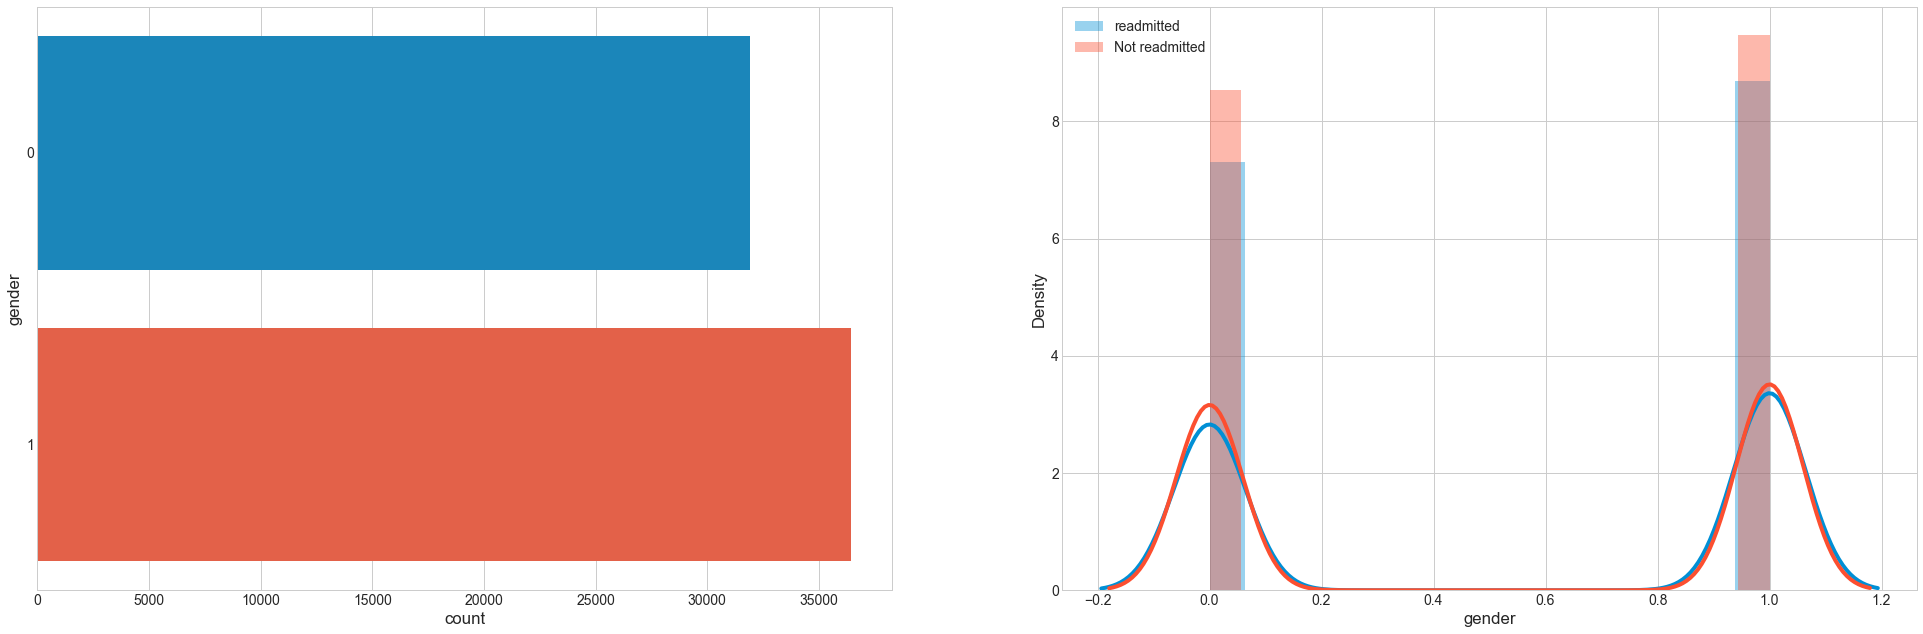

In [31]:
# Plot counts and distributions of readmitted and gender variables side by side. 
# Here Males are identified with the number 0 and Females by 1.
fig = plt.figure(figsize= (30,10))

plt.subplot(1,2,1)
sns.countplot(y= 'gender', data= df)

plt.subplot(1,2,2)

sns.distplot(df.loc[df['readmitted'] == 'Y']['gender'], label= 'readmitted')
sns.distplot(df.loc[df['readmitted'] == 'N']['gender'], label= 'Not readmitted')

plt.legend()
plt.show()

> Here we can see that there is a large number Female patients being readmitted compared to the Male patients. It can also be seen that the ratio of getting readmitted is less for Male patients.

FEATURE 5: Age

Description: The age of the patients.

**The values are given in bins of size 10.**

In [32]:
# How many missing values are there in the Age column
df['age'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='age'>

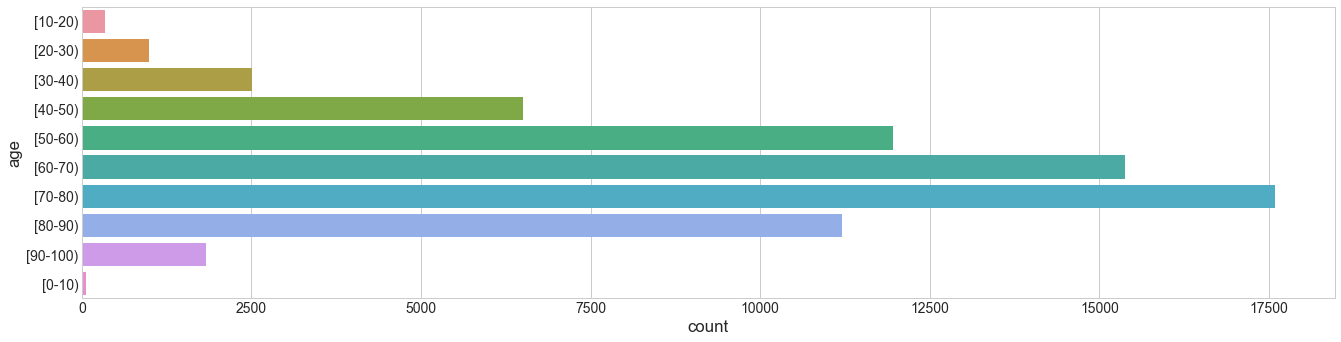

In [33]:
# How many patients are there in each age group?
fig = plt.figure(figsize=(20,5))
sns.countplot(y= 'age', data= df)
#sns.countplot(x= 'age', data= df)             --> You can use this to get a vertical graph.

> We can see that most of the patients fall under tha age category [70-80).

FEATURE 6: Admission Type

Description: The reason why the patient was brought in.

**The values are from 1 to 8.**  
- 1	    -->                    **Emergency**
- 2	    -->                    **Urgent**
- 3	    -->                    **Elective**
- 4	    -->                    **Newborn**
- 5	    -->                    **Not Available**
- 6	    -->                    **NULL**
- 7	    -->                    **Trauma Center**
- 8	    -->                    **Not Mapped**

In [34]:
# How many missing values are there in the Admission Type column
df['admission_type_id'].isnull().sum()

0

1    35000
3    13337
2    12211
6     4436
5     3061
8      283
7       20
4        9
Name: admission_type_id, dtype: int64


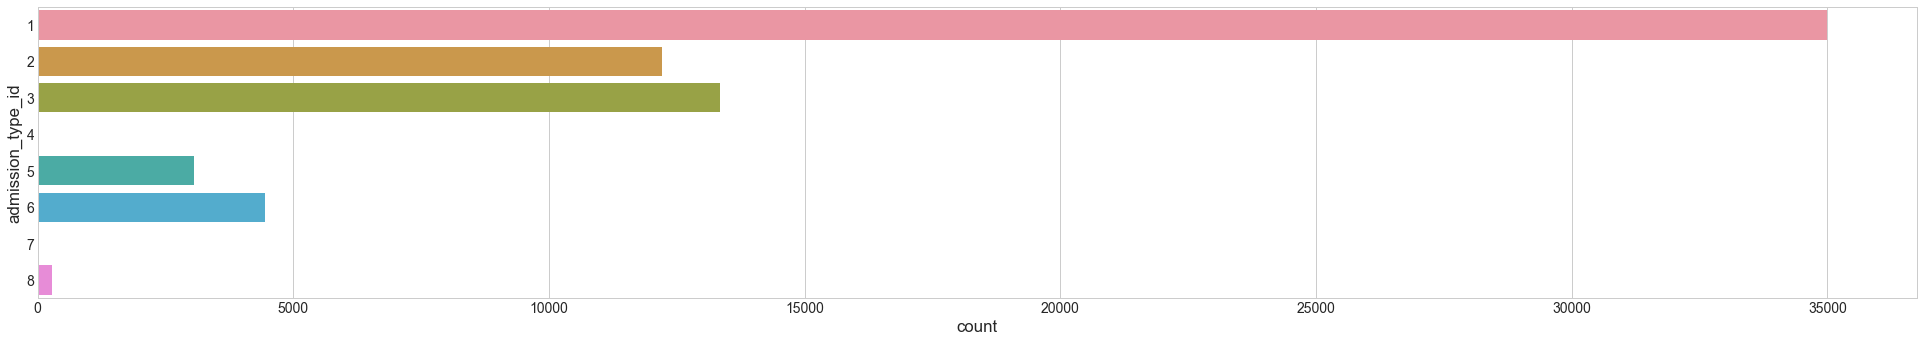

In [35]:
# How many patients visited the hospital for each type?
fig = plt.figure(figsize=(30,5))
sns.countplot(y= 'admission_type_id', data= df)
#sns.countplot(x= 'admission_type_id', data= df)             --> You can use this to get a vertical graph.

print(df['admission_type_id'].value_counts())             ##This will help us see the exact number along with the graph.

> Since the count of 4 and 7 is pretty low here I will be removing those values from here.

In [36]:
df = df[df['admission_type_id'] != 4]
df = df[df['admission_type_id'] != 7]

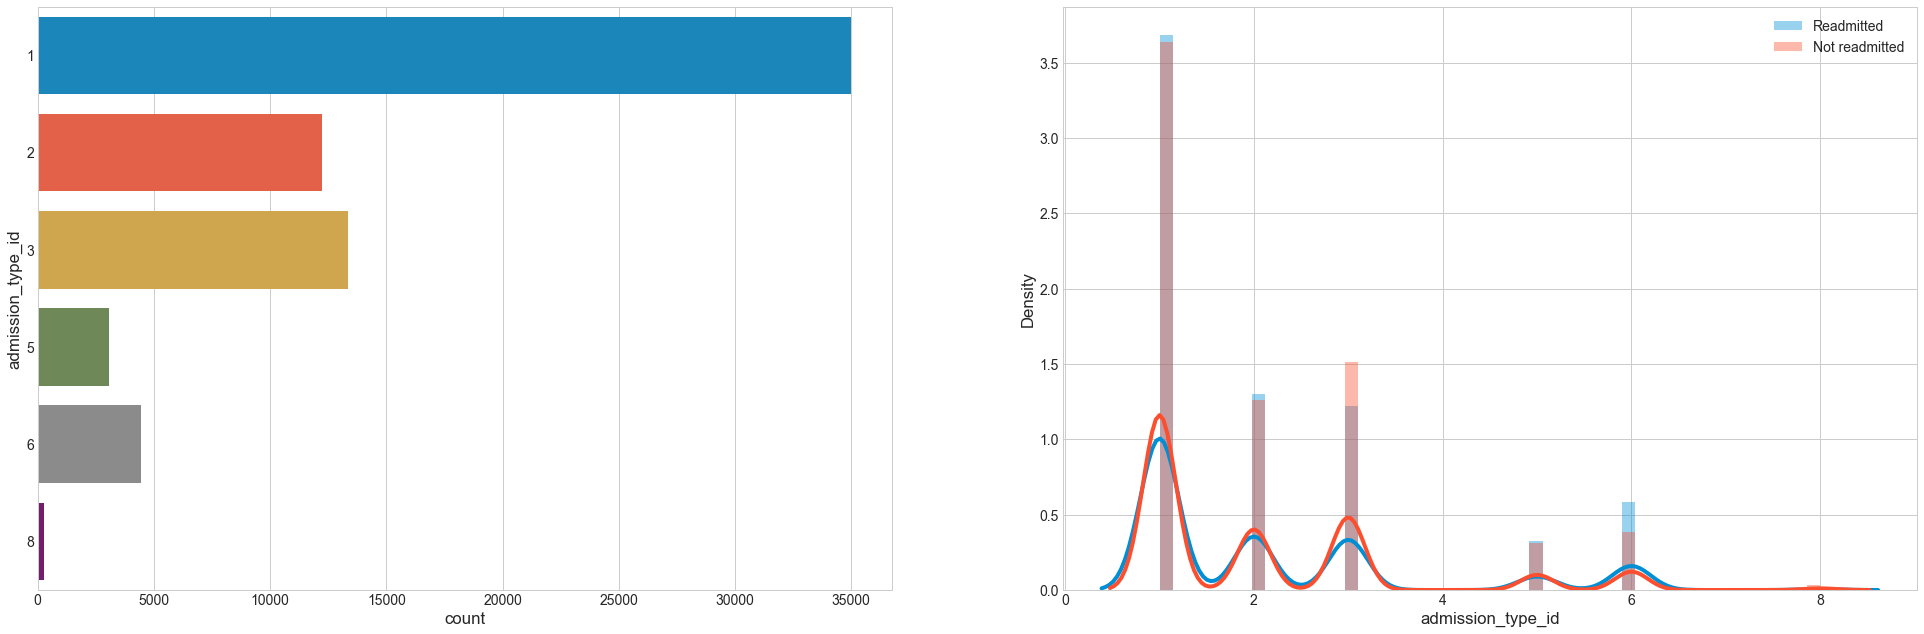

In [37]:
# How many patients visited the hospital for each type?
fig = plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
sns.countplot(y= 'admission_type_id', data= df)

plt.subplot(1,2,2)
sns.distplot(df.loc[df['readmitted'] == 'Y']['admission_type_id'], label= 'Readmitted')
sns.distplot(df.loc[df['readmitted'] == 'N']['admission_type_id'], label= 'Not readmitted')

plt.legend()
plt.show()

> Here we can see that the patients who come under the category: 
- Emergency (1)
- Urgent (2)
- Not Available (5)
- Null (6) --> Fairly higher chance.

> are those group who show a comparatively more chance of returning to the hospital.

> It is important to note that the patients who come under the category Elective are less likely to get readmitted.

FEATURE 7: Discharge Disposition

Description: The place where the patient was discharged to.

**The values are from 1 to 29.**  
- 1     --> 	**Discharged to home**
- 2     --> 	**Discharged/transferred to another short term hospital**
- 3     --> 	**Discharged/transferred to SNF**
- 4     --> 	**Discharged/transferred to ICF**
- 5     --> 	**Discharged/transferred to another type of inpatient care institution**
- 6	    -->     **Discharged/transferred to home with home health service**
- 7     --> 	**Left AMA**
- 8     --> 	**Discharged/transferred to home under care of Home IV provider**
- 9     --> 	**Admitted as an inpatient to this hospital**
- 10    --> 	**Neonate discharged to another hospital for neonatal aftercare**
- 11    --> 	**Expired**
- 12    --> 	**Still patient or expected to return for outpatient services**
- 13    --> 	**Hospice / home**
- 14    --> 	**Hospice / medical facility**
- 15    --> 	**Discharged/transferred within this institution to Medicare approved swing bed**
- 16    --> 	**Discharged/transferred/referred another institution for outpatient services**
- 17    --> 	**Discharged/transferred/referred to this institution for outpatient services**
- 18    --> 	**NULL**
- 19    --> 	**Expired at home. Medicaid only, hospice.**
- 20    --> 	**Expired in a medical facility. Medicaid only, hospice.**
- 21    --> 	**Expired, place unknown. Medicaid only, hospice.**
- 22    --> 	**Discharged/transferred to another rehab fac including rehab units of a hospital .**
- 23    --> 	**Discharged/transferred to a long term care hospital.**
- 24    --> 	**Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.**
- 25    --> 	**Not Mapped**
- 26    --> 	**Unknown/Invalid**
- 30    --> 	**Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere**
- 27    --> 	**Discharged/transferred to a federal health care facility.**
- 28    --> 	**Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital**
- 29     --> 	**Discharged/transferred to a Critical Access Hospital (CAH).**


In [38]:
# How many missing values are there in the Discharge Disposition column
df['discharge_disposition_id'].isnull().sum()

0

> Here we will also remove all encounters that resulted in either discharge to a hospice or patient death or unknown or NULL, to avoid biasing our analysis.

In [39]:
# Removing the unnecessary value.
df = df[df['discharge_disposition_id'] != 11]
df = df[df['discharge_disposition_id'] != 13]
df = df[df['discharge_disposition_id'] != 14]
df = df[df['discharge_disposition_id'] != 18]
df = df[df['discharge_disposition_id'] != 19]
df = df[df['discharge_disposition_id'] != 20]
df = df[df['discharge_disposition_id'] != 21]
df = df[df['discharge_disposition_id'] != 26]
df = df[df['discharge_disposition_id'] != 25]

<AxesSubplot:xlabel='count', ylabel='discharge_disposition_id'>

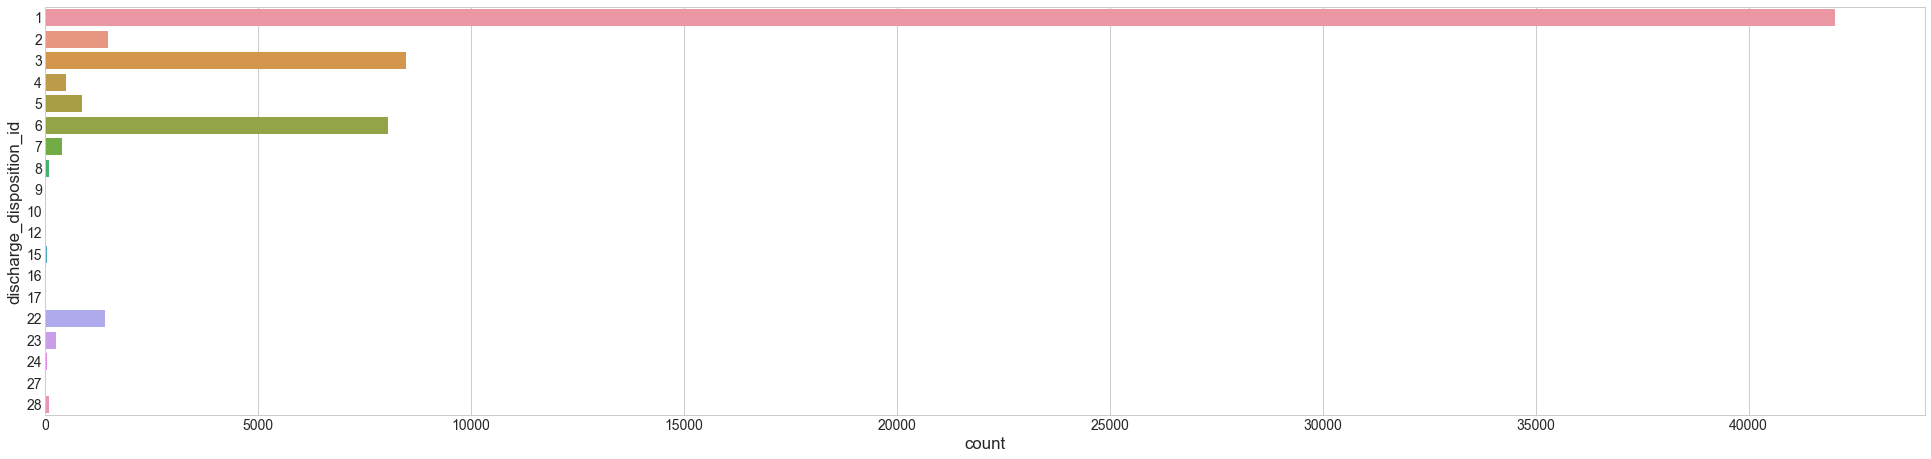

In [40]:
# How many patients were discharged from the hospital to different places?
fig = plt.figure(figsize=(30,7))
sns.countplot(y= 'discharge_disposition_id', data= df)

In [41]:
# Removing the value that have a low count.
df = df[df['discharge_disposition_id'] != 8]
df = df[df['discharge_disposition_id'] != 9]
df = df[df['discharge_disposition_id'] != 10]
df = df[df['discharge_disposition_id'] != 12]
df = df[df['discharge_disposition_id'] != 15]
df = df[df['discharge_disposition_id'] != 16]
df = df[df['discharge_disposition_id'] != 17]
df = df[df['discharge_disposition_id'] != 24]
df = df[df['discharge_disposition_id'] != 27]
df = df[df['discharge_disposition_id'] != 28]

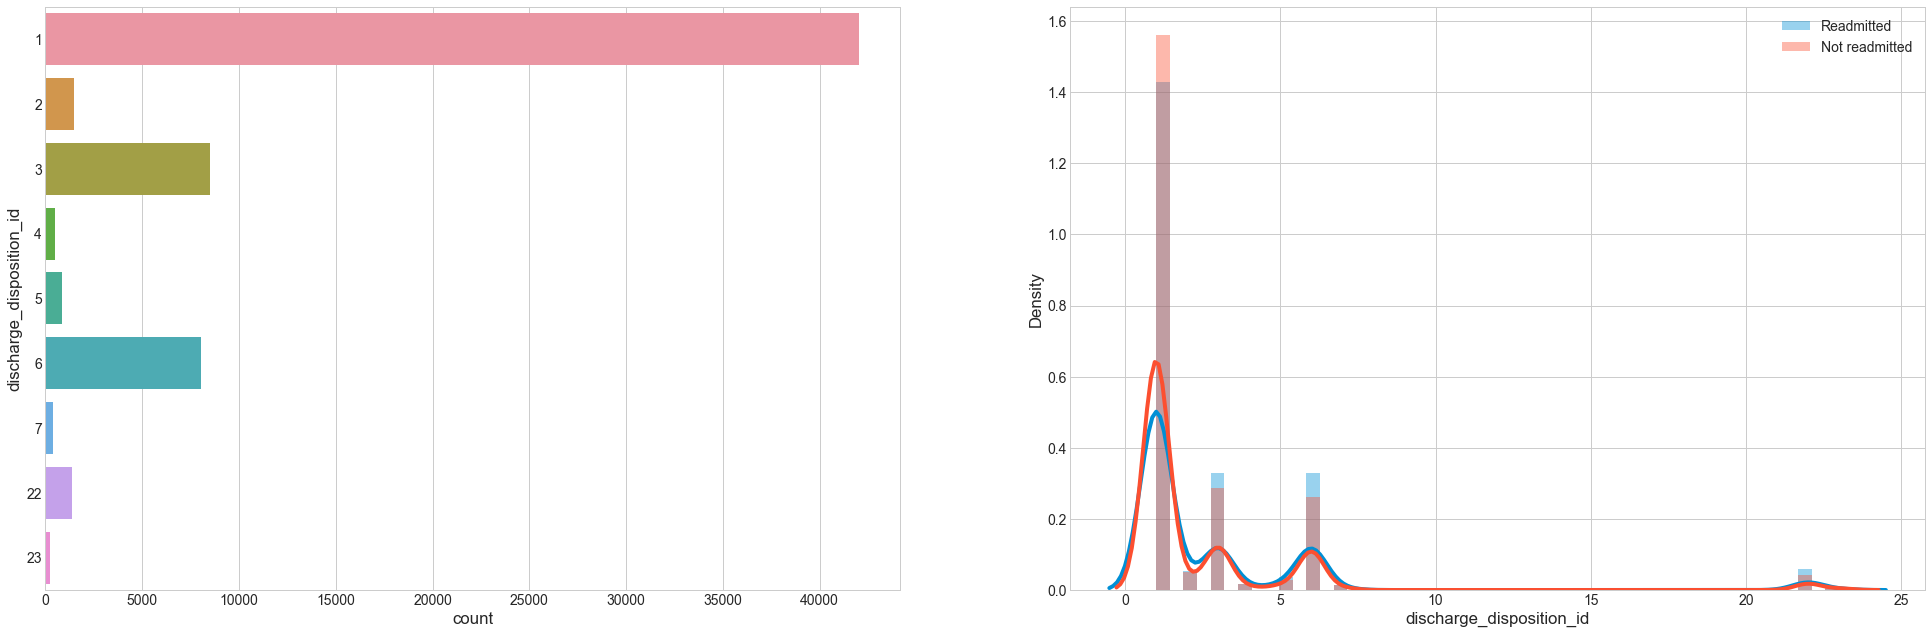

In [42]:
# How many patients were discharged from the hospital to different places?
fig = plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
sns.countplot(y= 'discharge_disposition_id', data= df)

plt.subplot(1,2,2)
sns.distplot(df.loc[df['readmitted'] == 'Y']['discharge_disposition_id'], label= 'Readmitted')
sns.distplot(df.loc[df['readmitted'] == 'N']['discharge_disposition_id'], label= 'Not readmitted')

plt.legend()
plt.show()

> This we can see that patients who fall in the category:
- 3 (Discharged/transferred to SNF).
- 5 (Discharged/transferred to another type of inpatient care institution).
- 6 (Discharged/transferred to home with home health service). 
- 23 (Discharged/transferred to a long term care hospital) 
show a high chance of returning.

> Whereas the patients who were Discharged to home (1) do not show the trend of being readmitted.

FEATURE 8: Time in hospital

Description: The time spent in the hospital.

**The values are from 1 to 14.**

In [43]:
# How many missing values are there in the Time in Hospital column
df['time_in_hospital'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='time_in_hospital'>

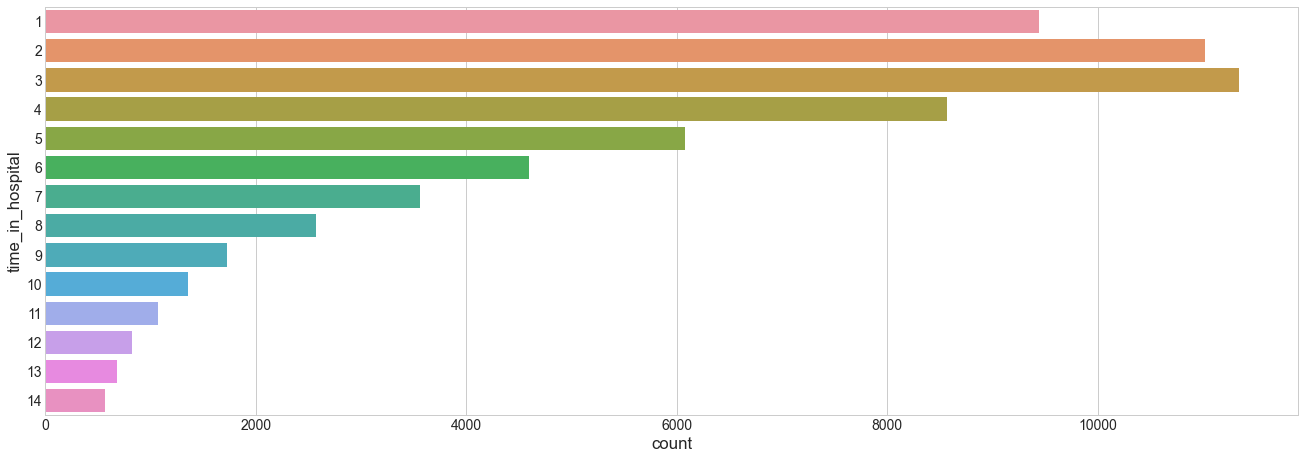

In [44]:
# How many patients were discharged from the hospital to different places?
fig = plt.figure(figsize=(20,7))
sns.countplot(y= 'time_in_hospital', data= df)

In [45]:
df['time_in_hospital'] = pd.cut(df['time_in_hospital'], bins= 5)

In [46]:
df.head()

encounter_id  patient_nbr             race  gender      age  \
1        149190   55629189.0        Caucasian       1  [10-20)   
2         64410   86047875.0  AfricanAmerican       1  [20-30)   
3        500364   82442376.0        Caucasian       0  [30-40)   
4         16680   42519267.0        Caucasian       0  [40-50)   
5         35754   82637451.0        Caucasian       0  [50-60)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   
5                  2                         1                    2   

  time_in_hospital medical_specialty  num_lab_procedures  num_procedures  \
1     (0.987, 3.6]           missing                  59               0   
2     (0.987, 3.6]           missing                  11               5   
3     (0.987, 3.6]           missing                  44               1   
4     (0.987, 3.6]           missing                  51               0   
5     (0.987, 3.6]           missing                  31               6   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   
5               16                  0                 0                 0   

  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
1    276  250.01    255                 9          None      None        No   
2    648     250    V27                 6          None      None        No   
3      8  250.43    403                 7          None      None        No   
4    197     157    250                 5          None      None        No   
5    414     411    250                 9          None      None        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   
5          No          No             No          No            No        No   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   
5        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   
5           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
1                  No                       No                      No   
2                  No                       No                      No   
3                  No                       No                      No   
4                  No                       No                      No   
5                  No                

<AxesSubplot:xlabel='count', ylabel='time_in_hospital'>

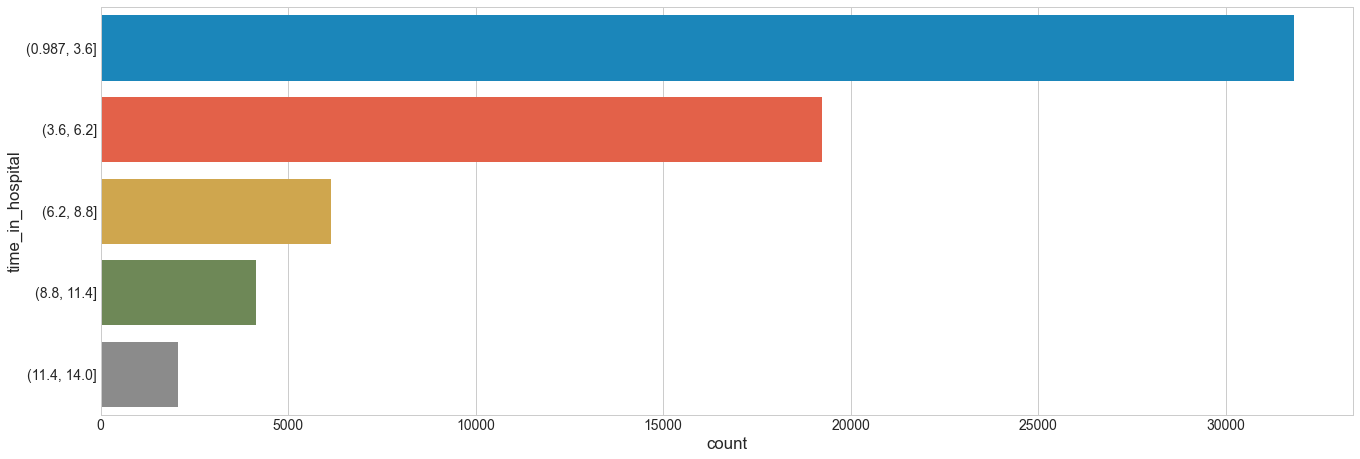

In [47]:
# How many patients were discharged from the hospital to different places? (in bins)
fig = plt.figure(figsize=(20,7))
sns.countplot(y= 'time_in_hospital', data= df)

FEATURE 9: Medical specialty

Description: Identifier the specialty of the admitting physician.

In [48]:
# How many missing values are there in the Medical specialty column
df['medical_specialty'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='medical_specialty'>

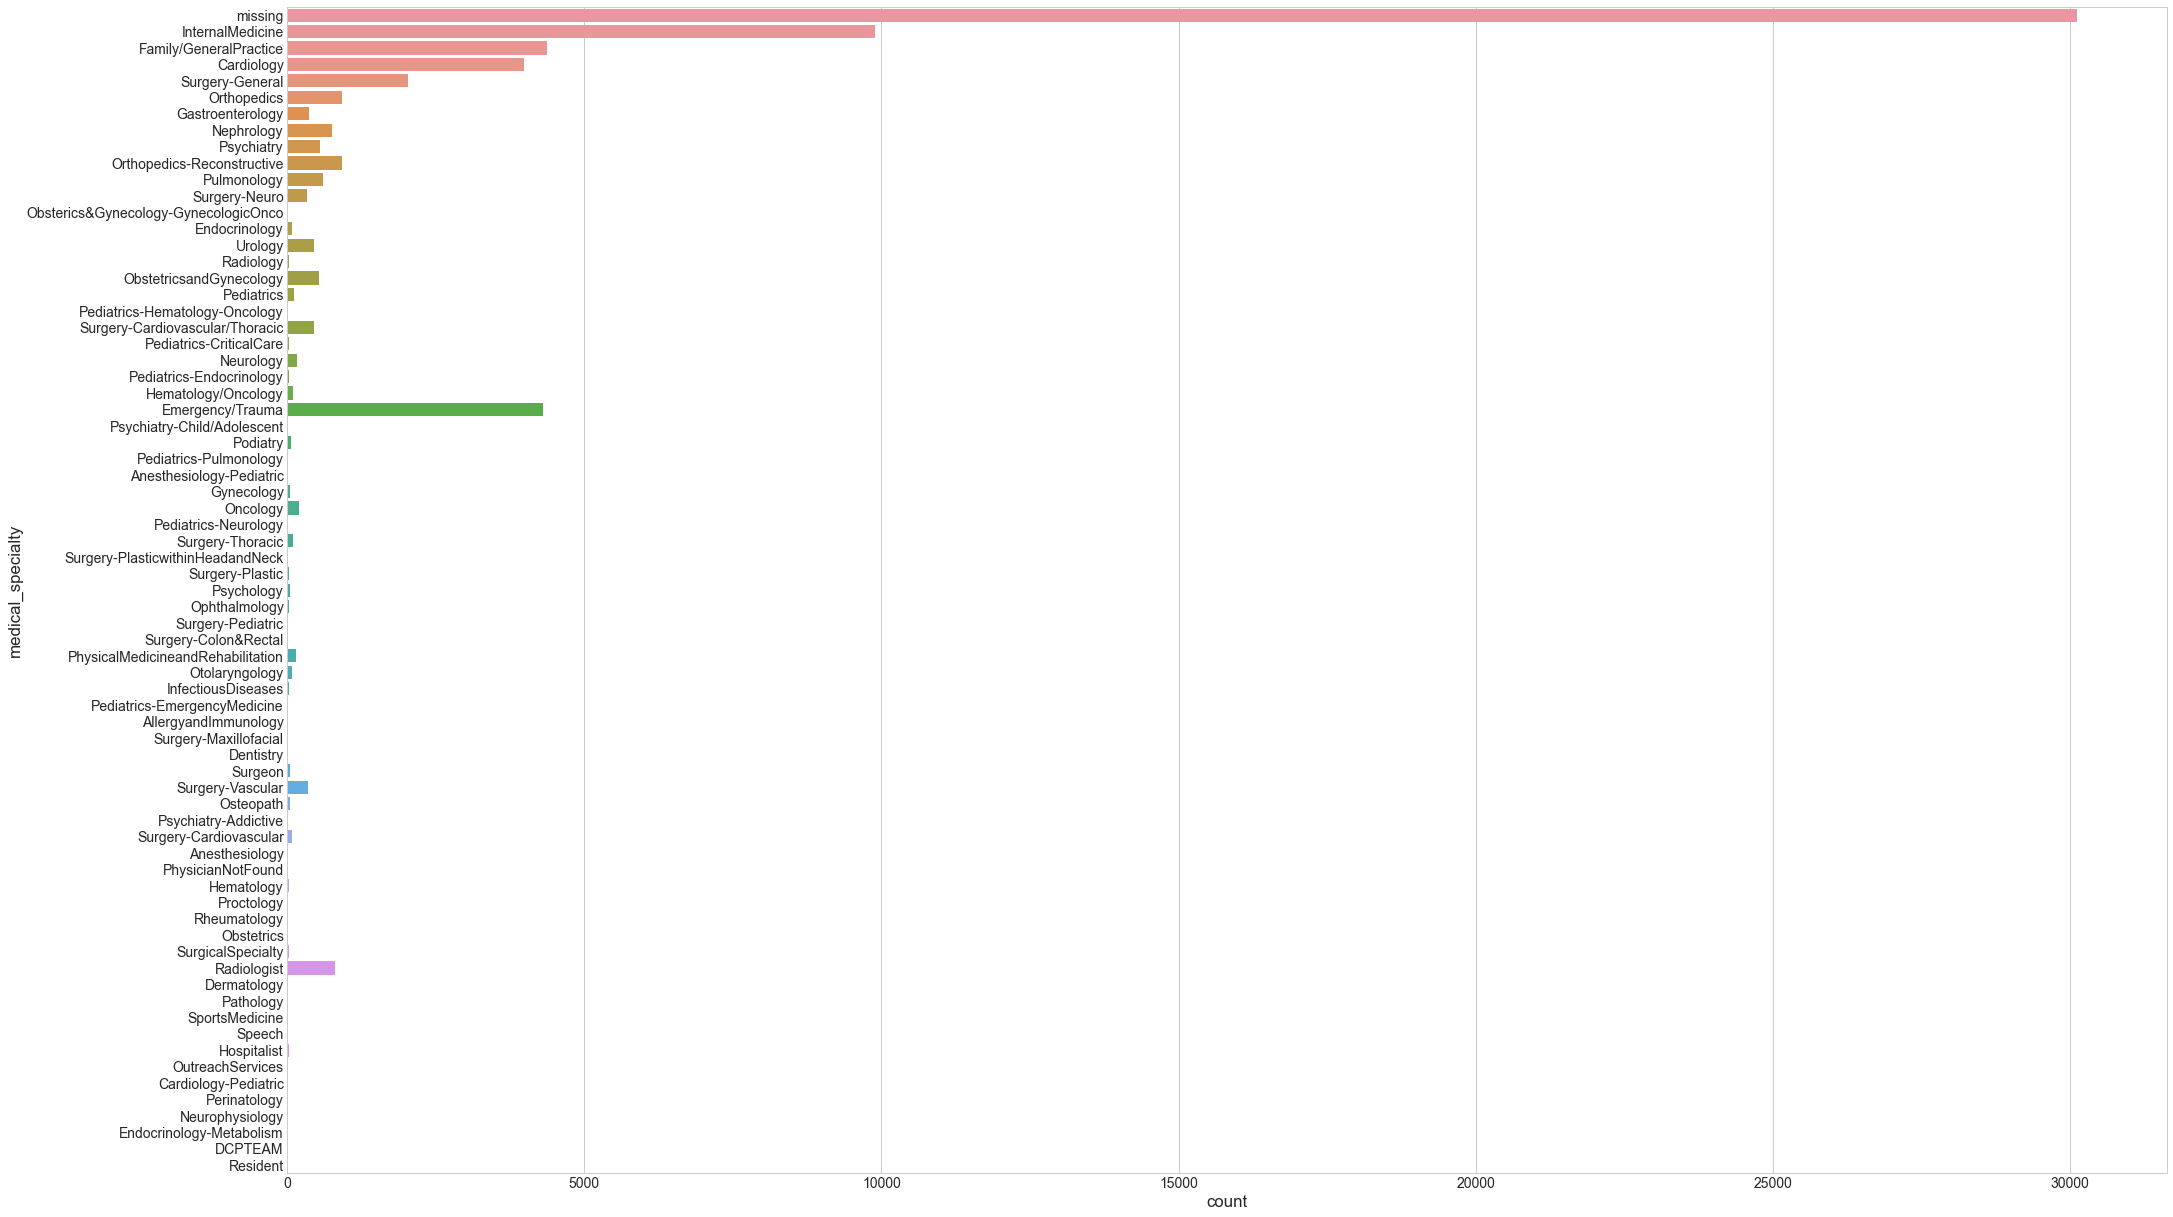

In [49]:
# which practioneer did most patients visit?
fig = plt.figure(figsize=(30,20))
sns.countplot(y= 'medical_specialty', data= df)

FEATURE 10: Number of lab procedures

Description: Number of lab tests performed during the encounter

In [50]:
# How many missing values are there in the Medical specialty column
df['num_lab_procedures'].isnull().sum()

0

<AxesSubplot:xlabel='num_lab_procedures', ylabel='count'>

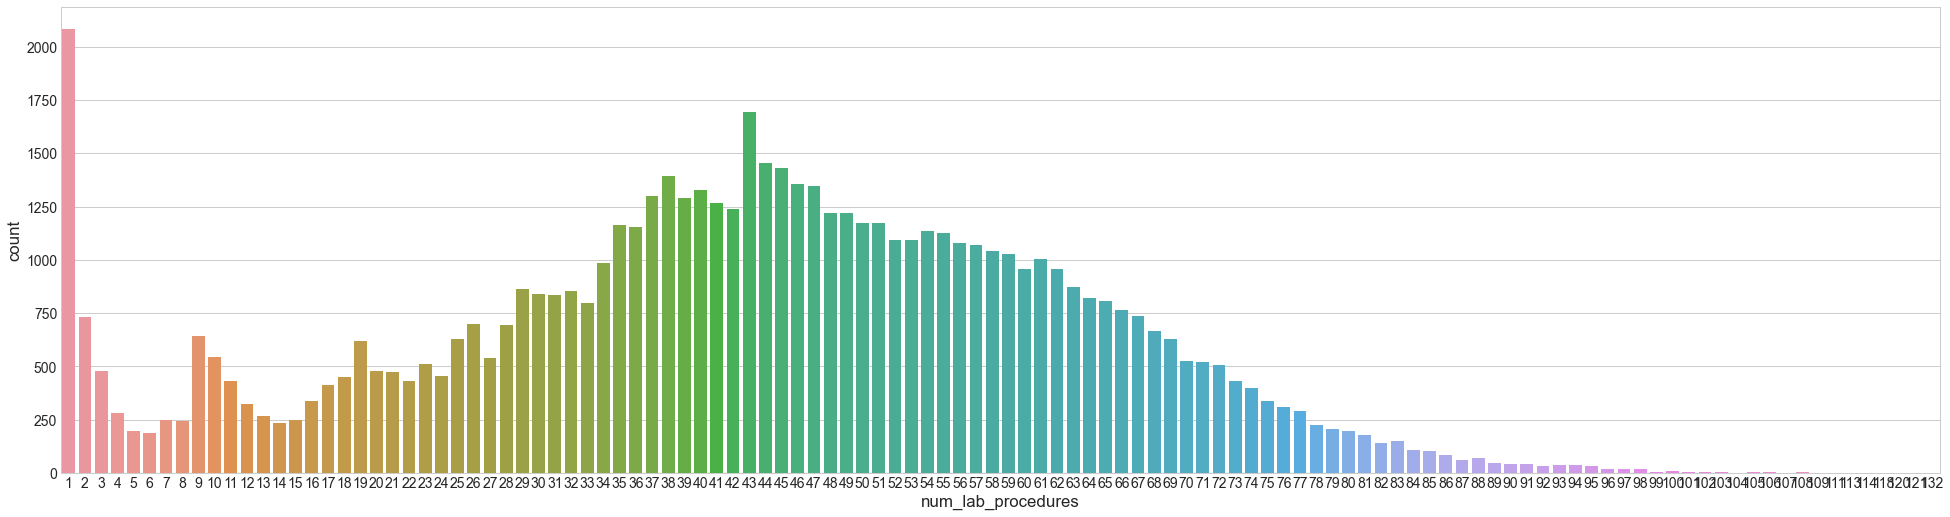

In [51]:
# How many lab tests did each patients take?
fig = plt.figure(figsize=(30,8))
sns.countplot(x= 'num_lab_procedures', data= df)

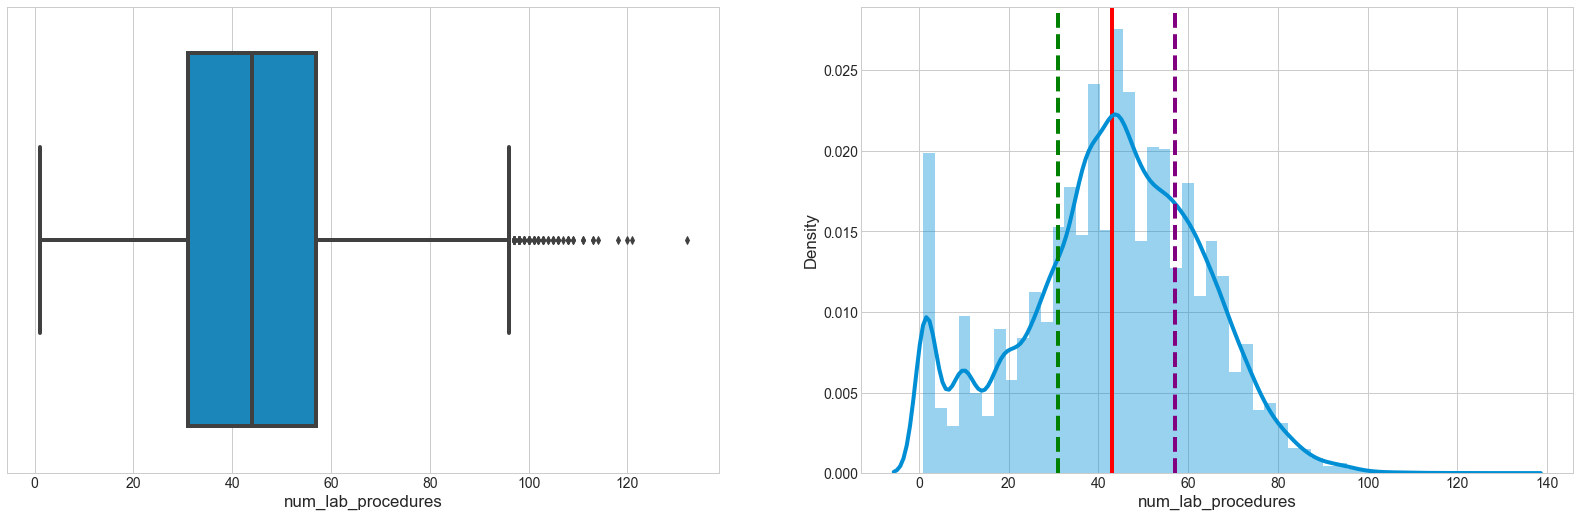

In [52]:
# Plotting box and distribution plots to get more understanding.
fig = plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
sns.boxplot(x= 'num_lab_procedures', data= df) # Using boxplot to see any outliers.

plt.subplot(1,2,2)
plt.axvline(np.mean(df['num_lab_procedures']),c= 'red') # to get the mean of this distribution
sns.distplot(df['num_lab_procedures']) 
plt.axvline(np.percentile(df['num_lab_procedures'],25),c= 'green', ls= '--') # To get the 25th qurtile
plt.axvline(np.percentile(df['num_lab_procedures'],75),c= 'purple', ls= '--') # To get the 75th qurtile

plt.show()

FEATURE 11: Number of medications

Description: Number of medications administered during the encounter.

In [53]:
# How many missing values are there in the Number of medications column
df['num_medications'].isnull().sum()

0

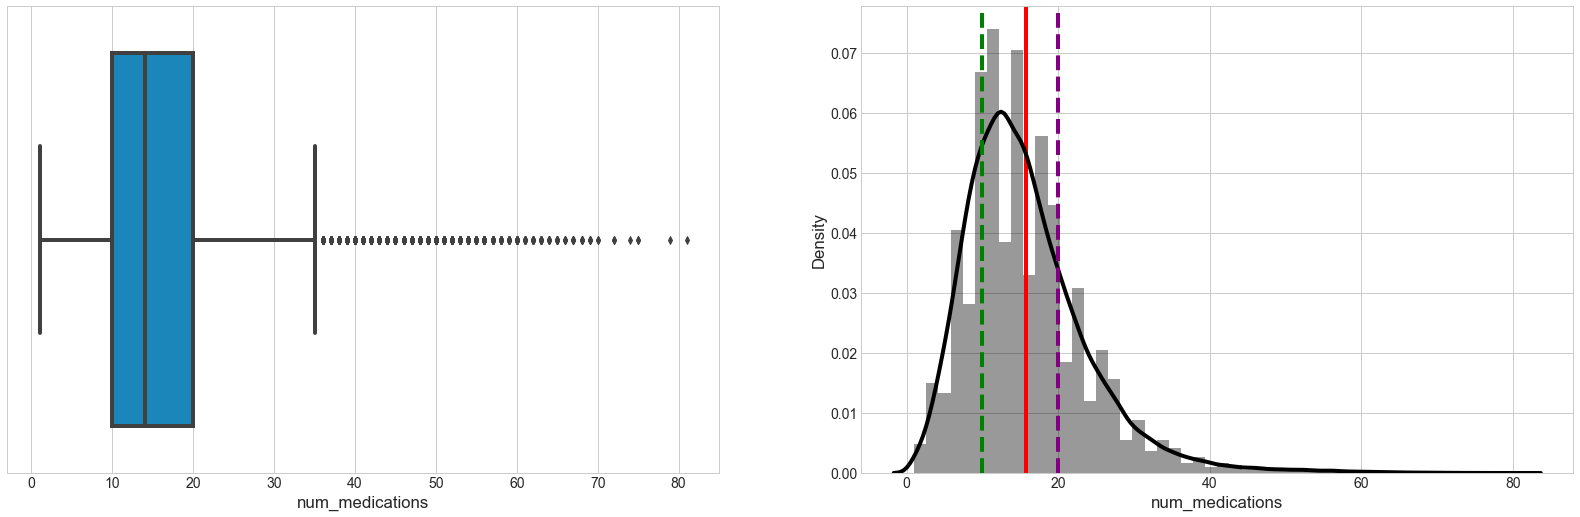

In [54]:
# Plotting box and distribution plots to get more understanding.
fig = plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
sns.boxplot(x= 'num_medications', data= df) # Using boxplot to see any outliers.

plt.subplot(1,2,2)
plt.axvline(np.mean(df['num_medications']),c= 'red') # to get the mean of this distribution
sns.distplot(df['num_medications'], color= 'black') 
plt.axvline(np.percentile(df['num_medications'],25),c= 'green', ls= '--') # To get the 25th qurtile
plt.axvline(np.percentile(df['num_medications'],75),c= 'purple', ls= '--') # To get the 75th qurtile

FEATURE 12: Diagnosis 1, Diagnosis 2 & Diagnosis 3

Description: The diagnosis the patient has taken to Diabetes.

In [55]:
# Did any Patient miss their initial diagnosis.
df['diag_1'].isnull().sum()

0

In [56]:
# Did any Patient miss their second diagnosis.
df['diag_2'].isnull().sum()

0

In [57]:
# Did any Patient miss their final diagnosis.
df['diag_3'].isnull().sum()

0

In [58]:
# Function to clean our 'diagnosis' column.
def cleaning(value):
    if "." in value:
        point = value.split(".")
        return point[0]
    else:
        return value

In [59]:
df["diag_1"] = df['diag_1'].apply(cleaning)
df["diag_2"] = df['diag_2'].apply(cleaning)
df["diag_3"] = df['diag_3'].apply(cleaning)

In [60]:
df.head()

encounter_id  patient_nbr             race  gender      age  \
1        149190   55629189.0        Caucasian       1  [10-20)   
2         64410   86047875.0  AfricanAmerican       1  [20-30)   
3        500364   82442376.0        Caucasian       0  [30-40)   
4         16680   42519267.0        Caucasian       0  [40-50)   
5         35754   82637451.0        Caucasian       0  [50-60)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   
5                  2                         1                    2   

  time_in_hospital medical_specialty  num_lab_procedures  num_procedures  \
1     (0.987, 3.6]           missing                  59               0   
2     (0.987, 3.6]           missing                  11               5   
3     (0.987, 3.6]           missing                  44               1   
4     (0.987, 3.6]           missing                  51               0   
5     (0.987, 3.6]           missing                  31               6   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   
5               16                  0                 0                 0   

  diag_1 diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
1    276    250    255                 9          None      None        No   
2    648    250    V27                 6          None      None        No   
3      8    250    403                 7          None      None        No   
4    197    157    250                 5          None      None        No   
5    414    411    250                 9          None      None        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   
5          No          No             No          No            No        No   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   
5        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   
5           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
1                  No                       No                      No   
2                  No                       No                      No   
3                  No                       No                      No   
4                  No                       No                      No   
5                  No                      

In [61]:
# Here we are creating a new column that has only The patients who are diagnosed with Diabetes.
df['diag_dibet'] = ((df["diag_1"] == '250') | (df["diag_2"] == '250') | (df["diag_3"] == '250'))  # This will give booleans.

In [62]:
# Data Cleaning on the Diagnosis of Diabetes column.
df['diag_dibet'].replace(True, 250, inplace= True)  ## Here we are replacing all the true values with 250 as that is our icd9 code.
df = df[df['diag_dibet'] !=0]   ## Removing the rows that have 0.

df.head()

encounter_id  patient_nbr             race  gender      age  \
1        149190   55629189.0        Caucasian       1  [10-20)   
2         64410   86047875.0  AfricanAmerican       1  [20-30)   
3        500364   82442376.0        Caucasian       0  [30-40)   
4         16680   42519267.0        Caucasian       0  [40-50)   
5         35754   82637451.0        Caucasian       0  [50-60)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   
5                  2                         1                    2   

  time_in_hospital medical_specialty  num_lab_procedures  num_procedures  \
1     (0.987, 3.6]           missing                  59               0   
2     (0.987, 3.6]           missing                  11               5   
3     (0.987, 3.6]           missing                  44               1   
4     (0.987, 3.6]           missing                  51               0   
5     (0.987, 3.6]           missing                  31               6   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   
5               16                  0                 0                 0   

  diag_1 diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
1    276    250    255                 9          None      None        No   
2    648    250    V27                 6          None      None        No   
3      8    250    403                 7          None      None        No   
4    197    157    250                 5          None      None        No   
5    414    411    250                 9          None      None        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   
5          No          No             No          No            No        No   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   
5        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   
5           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
1                  No                       No                      No   
2                  No                       No                      No   
3                  No                       No                      No   
4                  No                       No                      No   
5                  No                      

In [63]:
print("Dimensionality of the dataset: ", df.shape)

Dimensionality of the dataset:  (24169, 49)


In [64]:
# Here also we check to see if there are any patients who have turned come for the diagnosis twice.
df['patient_nbr'].duplicated().any()

False

> Thus we can see that none of the patients are being duplicated.

In [65]:
# To see if the patients with diabetes were readmitted or not.
x = df.loc[df['readmitted'] == 'Y']['diag_dibet'].value_counts().iloc[0]
y = df.loc[df['readmitted'] == 'N']['diag_dibet'].value_counts().iloc[0]

print('Number of patients readmitted:', x)
print('Number of patients not readmitted:', y)

Number of patients readmitted: 9690
Number of patients not readmitted: 14479


- Here we can see that most of the patients who with diabetes were not readmitted.

FEATURE 13: Glucose serum test result

Description: Indicates the range of the result or if the test was not taken.

Key: ">200", ">300", "normal,", "none" = If not measured

In [66]:
# Are there any missing values?
df['max_glu_serum'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='max_glu_serum'>

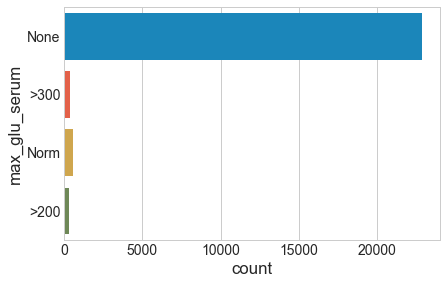

In [67]:
# To see which of the results hold a main role.
sns.countplot(y= 'max_glu_serum', data= df)

- Now here we can see that even though most of the patients have not done the test, it wouldnt be wise to drop this particulare feature. 

FEATURE 14: A1c test result

Description: Indicates the range of the HbA1c count.

Key: ">8", ">7", "normal",  "none" = If not measured.

In [68]:
# Are there any missing values?
df['A1Cresult'].isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='A1Cresult'>

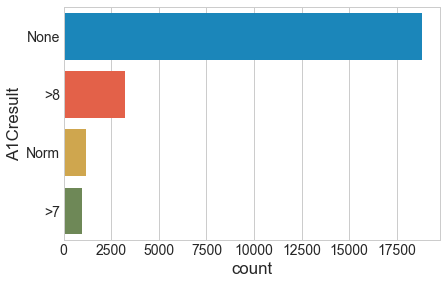

In [69]:
# To see which of the results is prominently seen in the patients.
sns.countplot(y= 'A1Cresult', data= df)

- Here also we can see that most of the patients havent taken the test. But we cant remove this column as this is the base of the whole data. The HbA1c is used to determine if the patient has diabetes or not.

FEATURE 15: Change of medications

Description: If there was a change in diabetic medications (either dosage or generic name).

Key:  "change" & "no change"

In [70]:
# Are there any missing values?
df['change'].isnull().sum()

0

In [71]:
df['change'].value_counts()

Ch    12123
No    12046
Name: change, dtype: int64

In [72]:
# Assigning the number 0 to all the No's and 1 to all the Ch (Changes).
df['change'] = np.where(df['change'] == 'No',0,1)

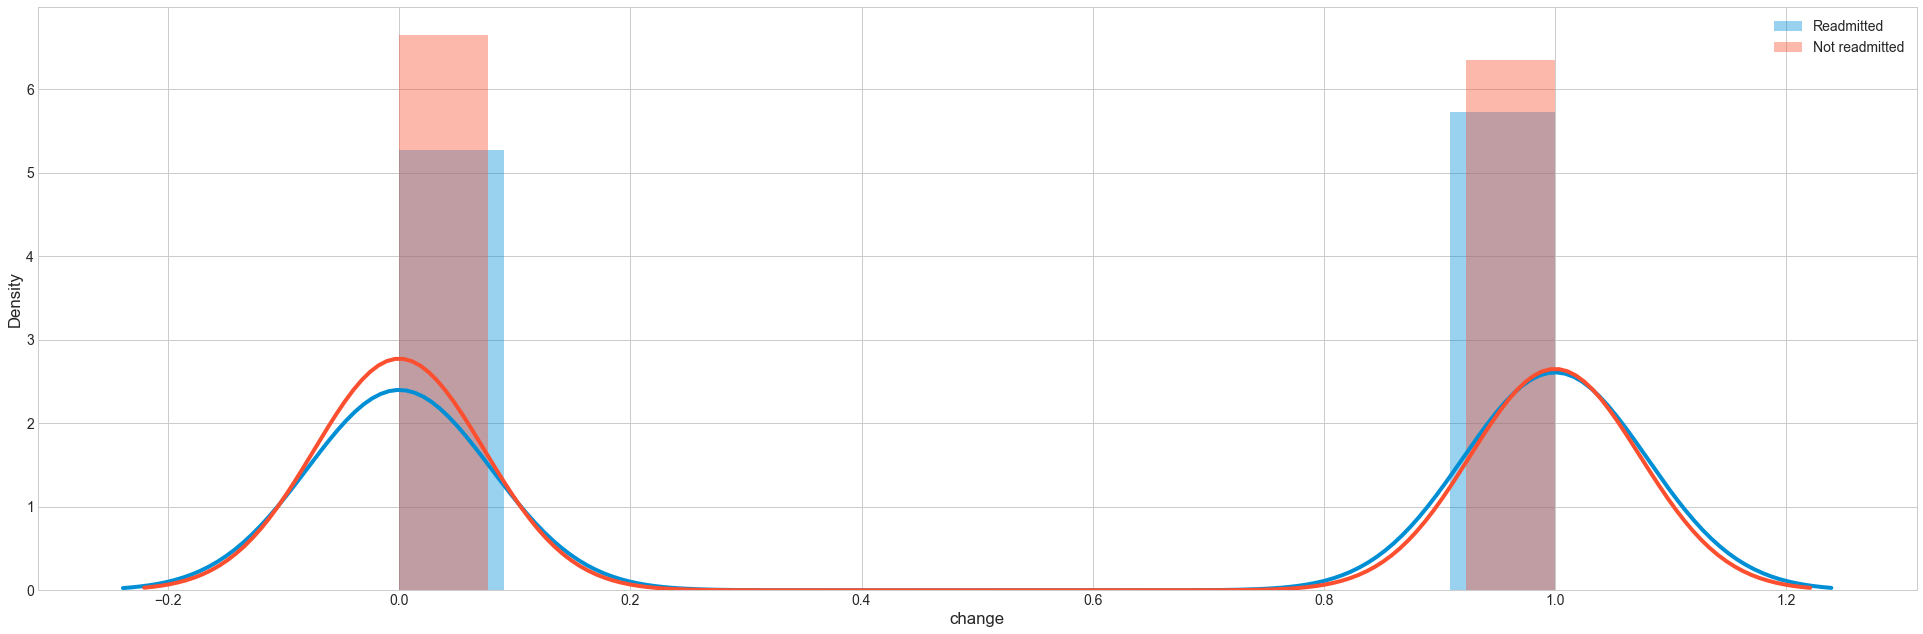

In [73]:
# How many patients has been Readmitted with and without change of medication?
fig = plt.figure(figsize=(30,10))

sns.distplot(df.loc[df['readmitted'] == 'Y']['change'], label= 'Readmitted')
sns.distplot(df.loc[df['readmitted'] == 'N']['change'], label= 'Not readmitted')

plt.legend()
plt.show()

> Here it is evident that even though there is no patient being readmitted, those patients who had not had a change in medicines has a far less ratio of being readmitted than the ones who had changed their medicine.

FEATURE 16: Diabetes medications

Description:  Indicates if there was any diabetic medication prescribed.

Key:  "Yes" & "No"

In [74]:
# Assigning the number 0 to all the No's and 1 to all the Yes's.
df['diabetesMed'] = np.where(df['diabetesMed'] == 'No',0,1)

1    19382
0     4787
Name: diabetesMed, dtype: int64


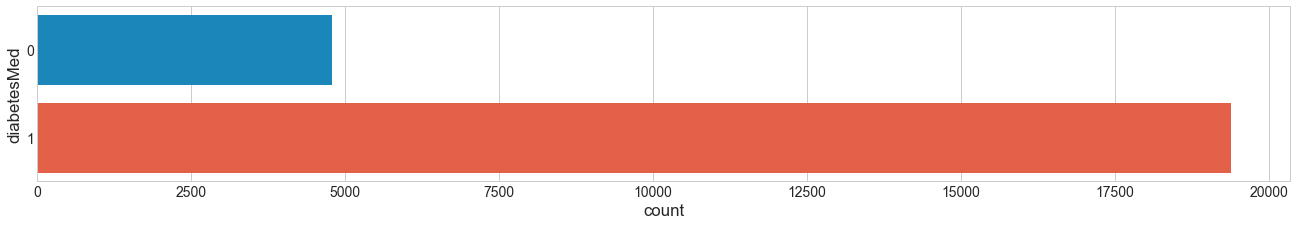

In [75]:
plt.figure(figsize=(20,3))
sns.countplot(y='diabetesMed',data= df)
print(df['diabetesMed'].value_counts())

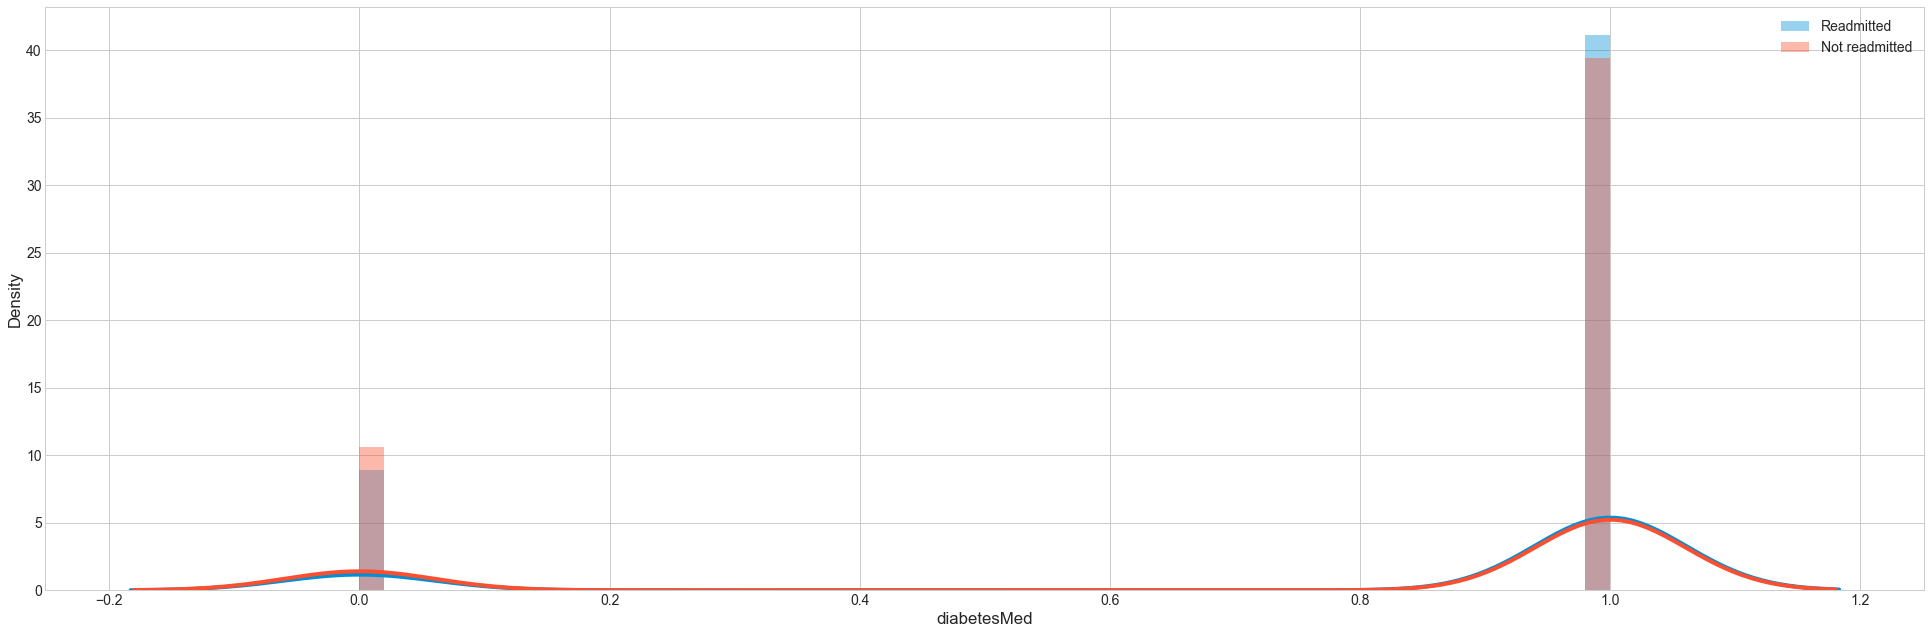

In [76]:
# How many patients were readmitted based on the intake of Diabetes Medicine.
fig = plt.figure(figsize=(30,10))

sns.distplot(df.loc[df['readmitted'] == 'Y']['diabetesMed'], label= 'Readmitted')
sns.distplot(df.loc[df['readmitted'] == 'N']['diabetesMed'], label= 'Not readmitted')

plt.legend()
plt.show()

> Here we can see that patients who have taken the Diabetes medicine are getting readmitted to the hospital. We might have believed  that those who dont take the medicine have a higher chance.

### We will be considering all the medications except a few for our future analysis.

> These required medications are:
- **metformin** 
- **repaglinide**  
- **nateglinide**  
- **glimepiride**
- **glyburide**  
- **pioglitazone**
- **rosiglitazone** 
- **miglitol**
- **insulin**
- **glyburide-metformin** 
- **glipizide-metformin**  
- **metformin-pioglitazone**


In [77]:
# Function to get the value counts of each medication column.
medication = ['metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glyburide', 'pioglitazone', 'rosiglitazone', 'miglitol', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-pioglitazone']


def get_value(df, columns):
    for i in columns:
        missing = df[i].isnull().sum()
        value = df[i].value_counts()
        print(f'The {i} have {missing} missing values with valuecounts = \n {value} \n')


get_value(df, columns= medication)

The metformin have 0 missing values with valuecounts = 
 No        18249
Steady     5371
Up          364
Down        185
Name: metformin, dtype: int64 

The repaglinide have 0 missing values with valuecounts = 
 No        23865
Steady      267
Up           30
Down          7
Name: repaglinide, dtype: int64 

The nateglinide have 0 missing values with valuecounts = 
 No        23996
Steady      163
Up            6
Down          4
Name: nateglinide, dtype: int64 

The glimepiride have 0 missing values with valuecounts = 
 No        22910
Steady     1138
Up           69
Down         52
Name: glimepiride, dtype: int64 

The glyburide have 0 missing values with valuecounts = 
 No        21683
Steady     2140
Up          218
Down        128
Name: glyburide, dtype: int64 

The pioglitazone have 0 missing values with valuecounts = 
 No        22264
Steady     1798
Up           77
Down         30
Name: pioglitazone, dtype: int64 

The rosiglitazone have 0 missing values with valuecounts = 
 No 

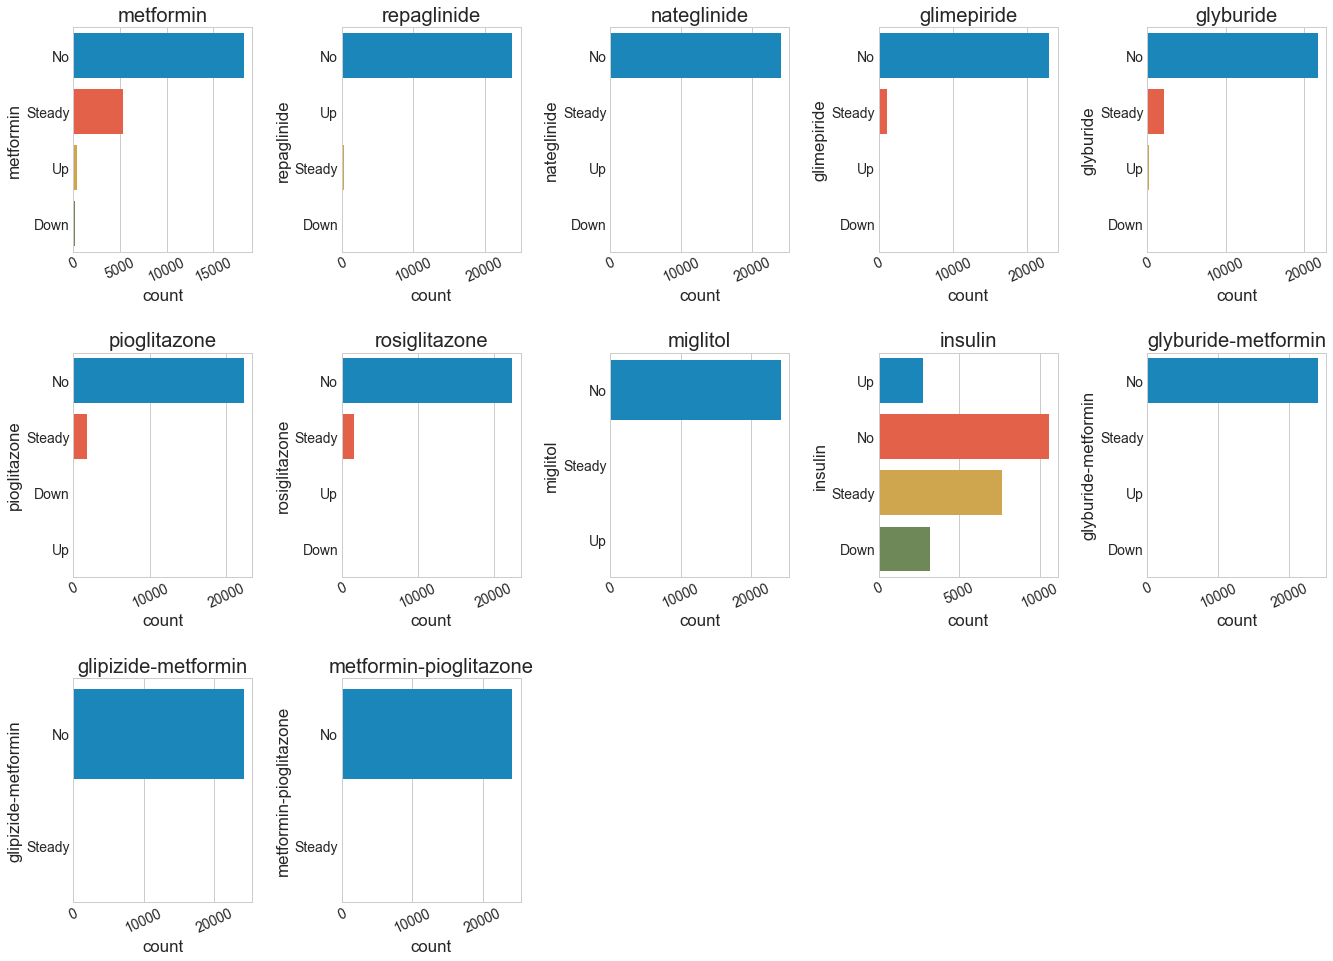

In [78]:
# Function to plot the value counts.
medication = ['metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glyburide', 'pioglitazone', 'rosiglitazone', 'miglitol', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-pioglitazone']


def plot_value(df, columns, rows= 4, cols= 3, width=40, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    for i, column in enumerate(columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        plot = sns.countplot(y= column,data= df)
        substrings = [s.get_text()[:18] for s in plot.get_yticklabels()]
        plot.set(yticklabels=substrings)
        plt.xticks(rotation=25)


plot_value(df, columns= medication, rows=3, cols= 5, width=20, height=15, hspace=0.45, wspace=0.5)

> Before we go for the bivariate analysis we will assign the features to a different dataframe.

In [79]:
# Creating a dataframe to add the required features. 
diabetes = pd.DataFrame()

In [80]:
# Adding the selected columns. 
# These are the major columns that we need for our Analysis.

diabetes['Readmitted'] = df['readmitted']
diabetes['Pmo'] = df['patient_nbr']
diabetes['Race'] = df['race']
diabetes['Sex'] = df['gender']
diabetes['Age'] = df['age']
diabetes['Admission_ID'] = df['admission_type_id']
diabetes['Discharged_ID'] = df['discharge_disposition_id']
diabetes['Time_in_Hospital'] = df['time_in_hospital']
diabetes['Procedures'] = df['num_lab_procedures']
diabetes['Medications'] = df['num_medications']
diabetes['Diagnosis'] = df['diag_dibet']
diabetes['Glu_result'] = df['max_glu_serum']
diabetes['A1C_result'] = df['A1Cresult']
diabetes['Change'] = df['change']
diabetes['Diabetes_Med'] = df['diabetesMed']
diabetes['metformin'] = df['metformin']
diabetes['repaglinide'] = df['repaglinide']
diabetes['nateglinide'] = df['nateglinide']
diabetes['glimepiride'] = df['glimepiride']
diabetes['glyburide'] = df['glyburide']
diabetes['pioglitazone'] = df['pioglitazone']
diabetes['rosiglitazone'] = df['rosiglitazone']
diabetes['miglitol'] = df['miglitol']
diabetes['insulin'] = df['insulin']
diabetes['glyburide-metformin'] = df['glyburide-metformin']
diabetes['glipizide-metformin'] = df['glipizide-metformin']
diabetes['metformin-pioglitazone'] = df['metformin-pioglitazone']

In [81]:
diabetes.head()

Readmitted         Pmo             Race  Sex      Age  Admission_ID  \
1          Y  55629189.0        Caucasian    1  [10-20)             1   
2          N  86047875.0  AfricanAmerican    1  [20-30)             1   
3          N  82442376.0        Caucasian    0  [30-40)             1   
4          N  42519267.0        Caucasian    0  [40-50)             1   
5          Y  82637451.0        Caucasian    0  [50-60)             2   

   Discharged_ID Time_in_Hospital  Procedures  Medications  Diagnosis  \
1              1     (0.987, 3.6]          59           18      250.0   
2              1     (0.987, 3.6]          11           13      250.0   
3              1     (0.987, 3.6]          44           16      250.0   
4              1     (0.987, 3.6]          51            8      250.0   
5              1     (0.987, 3.6]          31           16      250.0   

  Glu_result A1C_result  Change  Diabetes_Med metformin repaglinide  \
1       None       None       1             1        No          No   
2       None       None       0             1        No          No   
3       None       None       1             1        No          No   
4       None       None       1             1        No          No   
5       None       None       0             1        No          No   

  nateglinide glimepiride glyburide pioglitazone rosiglitazone miglitol  \
1          No          No        No           No            No       No   
2          No          No        No           No            No       No   
3          No          No        No           No            No       No   
4          No          No        No           No            No       No   
5          No          No        No           No            No       No   

  insulin glyburide-metformin glipizide-metformin metformin-pioglitazone  
1      Up                  No                  No                     No  
2      No                  No                  No                     No  
3      Up                  No                  No                     No  
4  Steady                  No                  No                     No  
5  Steady                  No                  No                     No

### BIVARIATE ANALYSIS

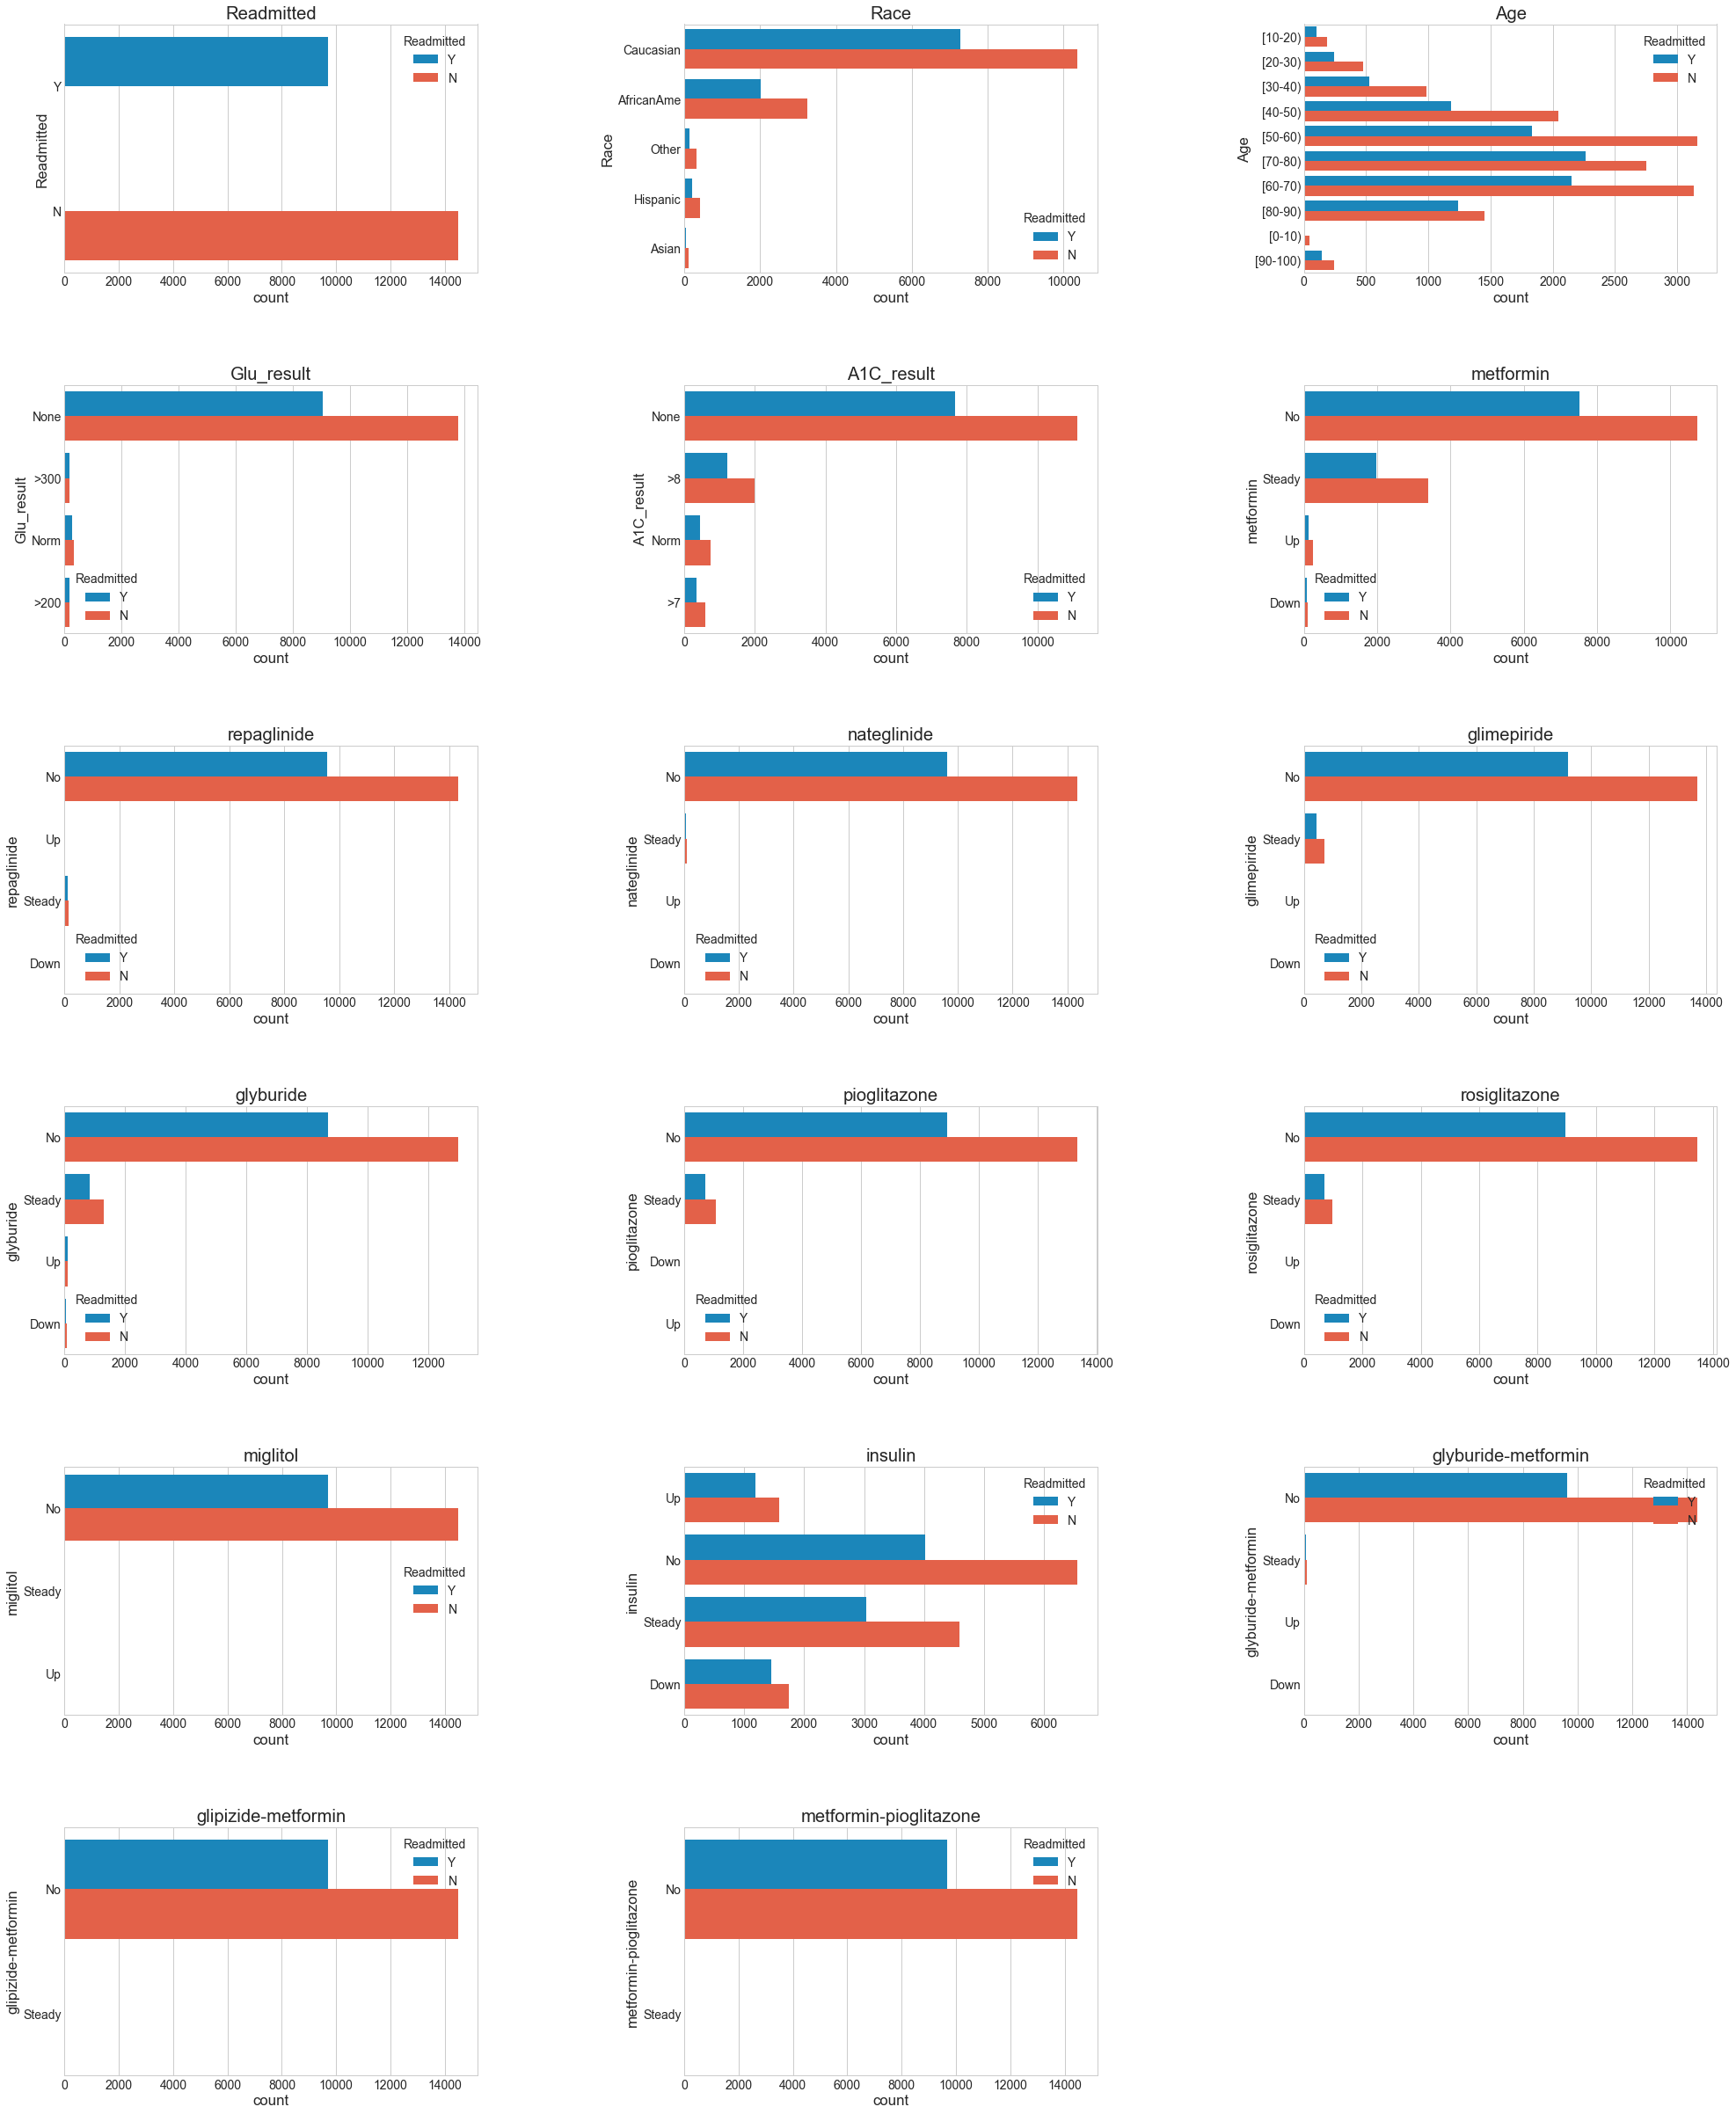

In [82]:
# Plot a count of the categories from each categorical feature split by our prediction class: 
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
plot_bivariate_bar(diabetes, hue='Readmitted', cols= 3, width= 30, height= 40, hspace= 0.45, wspace= 0.5)

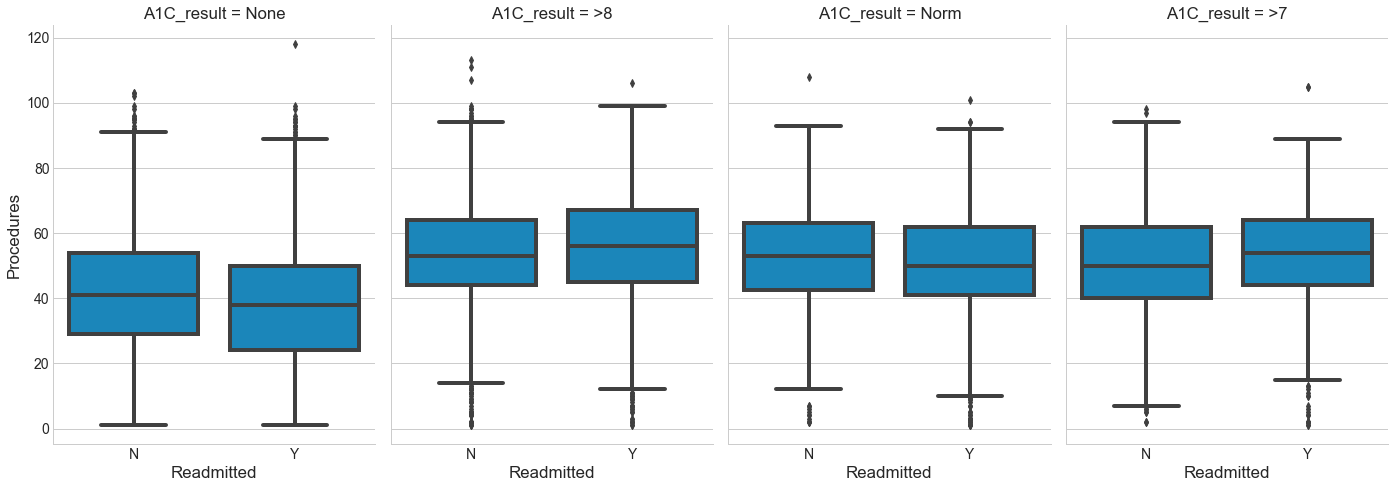

In [83]:
# Effect of A1C_result and Procedures on Readmitted, across A1C_result.
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(diabetes, col='A1C_result', size= 7, aspect= .7)
g = g.map(sns.boxplot, 'Readmitted', 'Procedures')

**From this we observe that:**

- In the cases when the A1c results are none or normal we can see that the patients who are being readmitted have a much higher median that those who are not readmitted.

- Also the interquartile range of the patients who arent readmitted is smaller in most cases, meaning the data of not patients readmitted is more consistent around median.